<h1>Weather: Preprocessing</h1>

<h3>Imports</h3>

In [2]:
import numpy as np
import pandas as pd

In [3]:
df_w_raw = pd.read_csv("weather_features.csv")

print(df_w_raw.head())

print(f"\nDataframe shape: {df_w_raw.shape}")

                      dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_i

<h3>Investigating Fields</h3>

In [4]:
# Counting the number of values in each column that are not 0 or null:
non_zero_or_null_count = [(col, df_w_raw[df_w_raw[col].notnull() & df_w_raw[col].ne(0)].shape[0]) for col in df_w_raw.columns]

df_non_zero_null_count = pd.DataFrame(non_zero_or_null_count, columns=["Column Name", "Non Zero/Null Count"])

print(df_non_zero_null_count)

unnecessary_columns = df_non_zero_null_count[df_non_zero_null_count["Non Zero/Null Count"] == 0]["Column Name"].tolist()

print(f"\nColumns with no useful data: {unnecessary_columns}")

#It can be seen that all columns have useful data.

null_count = df_w_raw.isnull().sum()

print("\nNull values in each column: ")
print(null_count)

print(f"\nAll columns and rows seem useful and filled.\n")

# min_values = df_w_raw.min()
# max_values = df_w_raw.max()

for column in df_w_raw.columns:
    print(f"{column}: min = {df_w_raw[column].min()}, max = {df_w_raw[column].max()}")

            Column Name  Non Zero/Null Count
0                dt_iso               178396
1             city_name               178396
2                  temp               178396
3              temp_min               178396
4              temp_max               178396
5              pressure               178394
6              humidity               178333
7            wind_speed               159906
8              wind_deg               153476
9               rain_1h                19388
10              rain_3h                 1855
11              snow_3h                  267
12           clouds_all                96202
13           weather_id               178396
14         weather_main               178396
15  weather_description               178396
16         weather_icon               178396

Columns with no useful data: []

Null values in each column: 
dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pr

<h3>Removing duplicate rows</h3>

In [5]:
duplicates = df_w_raw.duplicated()
print(f"Number of duplicate rows =  {duplicates.sum()}")

# print("Duplicated Rows:")
# print(df_w_raw[duplicates])

df_all_unique = df_w_raw.drop_duplicates()

duplicates2 = df_all_unique.duplicated()
print(f"Number of duplicate rows after processing =  {duplicates2.sum()}")


Number of duplicate rows =  21
Number of duplicate rows after processing =  0


<h3>Rounding variable decimals</h3>

In [6]:
# Round all values in temp, temp_min and temp_max to 3 dec. places:

#df_all_unique[["temp", "temp_min", "temp_max"]] = df_all_unique[["temp", "temp_min", "temp_max"]].round(3)

df_all_unique = df_all_unique.copy() # REF: https://www.dataquest.io/blog/settingwithcopywarning/
df_all_unique.loc[:, ["temp", "temp_min", "temp_max"]] = df_all_unique[["temp", "temp_min", "temp_max"]].round(3)


<h3>Qualitative Data Encoding</h3>

In [7]:
# HELPER FUNCTIONS

# Listing the occurrence of specific strings within column values: 
def list_keyword_occurrences(keyword_list, column_name):
    for keyword in keyword_list:
        count = df_all_unique[df_all_unique[column_name].str.contains(keyword, na=False)].shape[0]
        print(f"\"{keyword}\": {count}")

# Binning weather_main column for one-hot encoding: 
def bin_weather_main(weather):
    if weather in ["clear", "clouds"]:
        return weather
    elif weather in ["rain", "thunderstorm", "drizzle"]:
        return "rain"
    else:
        return "other"

# GENERAL ENCODING EXPLORATION

qual_columns = ["weather_main", "weather_description"]  

for column in qual_columns:
    print(f"\nCount of unique values for {column}: \n")
    print(df_all_unique[column].value_counts())

qual_unique_values_dict = {}

# WEATHER_MAIN COLUMN (BINNING AND ONE-HOT ENCODING)

# New dataframe with new binned column for weather main: 
df_all_unique["weather_main_binned"] = df_all_unique["weather_main"].map(bin_weather_main)
#print(df_all_unique.head())

# ohe = one-hot encoded
ohe_weather_main = pd.get_dummies(df_all_unique["weather_main_binned"], prefix="weather")

df_all_unique = pd.concat([df_all_unique, ohe_weather_main], axis=1)
print(f"\nNew dataframe with binned and one-hot encoded weather_main column:\n{df_all_unique.head()}\n")


# WEATHER DESCRIPTION EXPLORATION

# Determining the prevalence of various keywords: 

keywords = ["snow", "rain", "thunderstorm", "drizzle", "shower", "dust", "squalls", "proximity", "light", "heavy", "sand", "dust"]

print(f"\n\nPrevalence of keywords in the weather_description column:")
list_keyword_occurrences(keywords, "weather_description")


# Whilst these qualitative descriptions are insightful, it is felt that much of this description 
# ... can be attained from other columns with a higher resolution. For example, temperature, humidity,
# ... wind speed, precipitation in the last hour and cloud cover basically give precise values for most 
# ... of what would be encapsulated in the descriptions anyway. 
# Therefore, only these columns will be extracted for now. 



Count of unique values for weather_main: 

clear           82670
clouds          68050
rain            17390
mist             3908
fog              2506
drizzle          1724
thunderstorm     1041
haze              435
dust              347
snow              270
smoke              33
squall              1
Name: weather_main, dtype: int64

Count of unique values for weather_description: 

sky is clear                    82670
few clouds                      32099
broken clouds                   17447
scattered clouds                15943
light rain                      10904
mist                             3908
moderate rain                    3621
overcast clouds                  2561
fog                              2506
light intensity drizzle          1241
heavy intensity rain             1142
light intensity shower rain       657
proximity thunderstorm            480
proximity shower rain             476
haze                              435
shower rain                       426


In [15]:
weather_columns = df_all_unique.columns.tolist() 
print(weather_columns)

['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main', 'weather_description', 'weather_icon', 'weather_main_binned', 'weather_clear', 'weather_clouds', 'weather_other', 'weather_rain']


<h3>Splitting Dataset and Investigating Individual City Data </h3>

In [8]:
cities = df_all_unique["city_name"].unique()
print("Unique cities: ", cities)


valencia_df = df_all_unique[df_all_unique["city_name"] == "Valencia"]
madrid_df = df_all_unique[df_all_unique["city_name"] == "Madrid"]
bilbao_df = df_all_unique[df_all_unique["city_name"] == "Bilbao"]
barcelona_df = df_all_unique[df_all_unique["city_name"] == " Barcelona"] # Note the space needed. 
seville_df = df_all_unique[df_all_unique["city_name"] == "Seville"]

#print(valencia_df.head())

print(f"valencia_df shape: {valencia_df.shape}.")
print(f"madrid_df shape: {madrid_df.shape}.")
print(f"bilbao_df shape: {bilbao_df.shape}.")
print(f"barcelona_df shape: {barcelona_df.shape}.")
print(f"seville_df shape: {seville_df.shape}.\n")

v_timedate_duplicates = valencia_df["dt_iso"].duplicated()
print(f"Number of duplicate values in time/date column for valencia_df =  {v_timedate_duplicates.sum()}.")
v_revised_len = valencia_df.shape[0] - v_timedate_duplicates.sum()
print(f"Valencia revised length: {v_revised_len}\n")

m_timedate_duplicates = madrid_df["dt_iso"].duplicated()
print(f"Number of duplicate values in time/date column for madrid_df =  {m_timedate_duplicates.sum()}.")
m_revised_len = madrid_df.shape[0] - m_timedate_duplicates.sum()
print(f"Madrid revised length: {m_revised_len}\n")

b_timedate_duplicates = bilbao_df["dt_iso"].duplicated()
print(f"Number of duplicate values in time/date column for bilbao_df =  {b_timedate_duplicates.sum()}.")
b_revised_len = bilbao_df.shape[0] - b_timedate_duplicates.sum()
print(f"Bilbao revised length: {b_revised_len}\n")

a_timedate_duplicates = barcelona_df["dt_iso"].duplicated()
print(f"Number of duplicate values in time/date column for barcelona_df =  {a_timedate_duplicates.sum()}.")
a_revised_len = barcelona_df.shape[0] - a_timedate_duplicates.sum()
print(f"Barcelona revised length: {a_revised_len}\n")

s_timedate_duplicates = seville_df["dt_iso"].duplicated()
print(f"Number of duplicate values in time/date column for seville_df =  {s_timedate_duplicates.sum()}.")
s_revised_len = seville_df.shape[0] - s_timedate_duplicates.sum()
print(f"Seville revised length: {s_revised_len}\n")

#Looking at duplicte rows: 

valencia_duplicates = valencia_df[valencia_df.duplicated(subset=["dt_iso"], keep=False)]
print(f"\nValencia Duplicate rows:\n{valencia_duplicates}")

madrid_duplicates = madrid_df[madrid_df.duplicated(subset=["dt_iso"], keep=False)]
print(f"\nMadrid Duplicate rows:\n{madrid_duplicates}")

bilbao_duplicates = bilbao_df[bilbao_df.duplicated(subset=["dt_iso"], keep=False)]
print(f"\nBilbao Duplicate rows:\n{bilbao_duplicates}")

barcelona_duplicates = barcelona_df[barcelona_df.duplicated(subset=["dt_iso"], keep=False)]
print(f"\nBarcelona Duplicate rows:\n{barcelona_duplicates}")

seville_duplicates = seville_df[seville_df.duplicated(subset=["dt_iso"], keep=False)]
print(f"\nSeville Duplicate rows:\n{seville_duplicates}")





Unique cities:  ['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville']
valencia_df shape: (35140, 22).
madrid_df shape: (36263, 22).
bilbao_df shape: (35947, 22).
barcelona_df shape: (35472, 22).
seville_df shape: (35553, 22).

Number of duplicate values in time/date column for valencia_df =  76.
Valencia revised length: 35064

Number of duplicate values in time/date column for madrid_df =  1199.
Madrid revised length: 35064

Number of duplicate values in time/date column for bilbao_df =  883.
Bilbao revised length: 35064

Number of duplicate values in time/date column for barcelona_df =  408.
Barcelona revised length: 35064

Number of duplicate values in time/date column for seville_df =  489.
Seville revised length: 35064


Valencia Duplicate rows:
                          dt_iso city_name    temp  temp_min  temp_max  \
3981   2015-06-15 21:00:00+02:00  Valencia  289.61    288.65    290.93   
3982   2015-06-15 21:00:00+02:00  Valencia  289.61    288.65    290.93   
3983   2015-06-15 

<h3>Removing duplicate rows for same date</h3>

In [9]:
# It looks as though the duplicates are due to slightly different qualitative descriptions of weather
# ... conditions. 

valencia_df_deduplicated = valencia_df.drop_duplicates(subset="dt_iso", keep="first")
madrid_df_deduplicated = madrid_df.drop_duplicates(subset="dt_iso", keep="first")
bilbao_df_deduplicated = bilbao_df.drop_duplicates(subset="dt_iso", keep="first")
barcelona_df_deduplicated = barcelona_df.drop_duplicates(subset="dt_iso", keep="first")
seville_df_deduplicated = seville_df.drop_duplicates(subset="dt_iso", keep="first")

print(f"These should all have rows = 35,064:\n")
print(f"valencia_df_deduplicated shape: {valencia_df_deduplicated.shape}")
print(f"madrid_df_deduplicated shape: {madrid_df_deduplicated.shape}")
print(f"bilbao_df_deduplicated shape: {bilbao_df_deduplicated.shape}")
print(f"barcelona_df_deduplicated shape: {barcelona_df_deduplicated.shape}")
print(f"seville_df_deduplicated shape: {seville_df_deduplicated.shape}")


#barcelona_df_deduplicated.to_csv("barcelona_df_deduplicated.csv", index=False)

These should all have rows = 35,064:

valencia_df_deduplicated shape: (35064, 22)
madrid_df_deduplicated shape: (35064, 22)
bilbao_df_deduplicated shape: (35064, 22)
barcelona_df_deduplicated shape: (35064, 22)
seville_df_deduplicated shape: (35064, 22)


<h3>Concatenating Dataframes to check they all align (+ reset indexes)</h3

In [10]:
# Indexes need to be reset otherwise the dataframes do not go next to each other and concatenate 
# ... diagonally. 

v_df = valencia_df_deduplicated.reset_index(drop=True)
m_df = madrid_df_deduplicated.reset_index(drop=True)
b_df = bilbao_df_deduplicated.reset_index(drop=True)
a_df = barcelona_df_deduplicated.reset_index(drop=True)
s_df = seville_df_deduplicated.reset_index(drop=True)

#combined_city_df = pd.concat([v_df, m_df, b_df, a_df, s_df], axis=1)
#combined_city_df.to_csv("combined_city_df.csv", index=False)

# All city dataframes now align exactly, all indexes have the same number of rows which match 
# ... each other. 

<h3>Prepending column headings so they are unique for each city</h3>

In [11]:
# REF: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.add_prefix.html
v_df = v_df.add_prefix("v_")
m_df = m_df.add_prefix("m_")
b_df = b_df.add_prefix("b_")
a_df = a_df.add_prefix("a_")
s_df = s_df.add_prefix("s_")

combined_city_df = pd.concat([v_df, m_df, b_df, a_df, s_df], axis=1)
#combined_city_df.to_csv("combined_city_df.csv", index=False)


<h3>Plotting Data for Different Cities</h3>

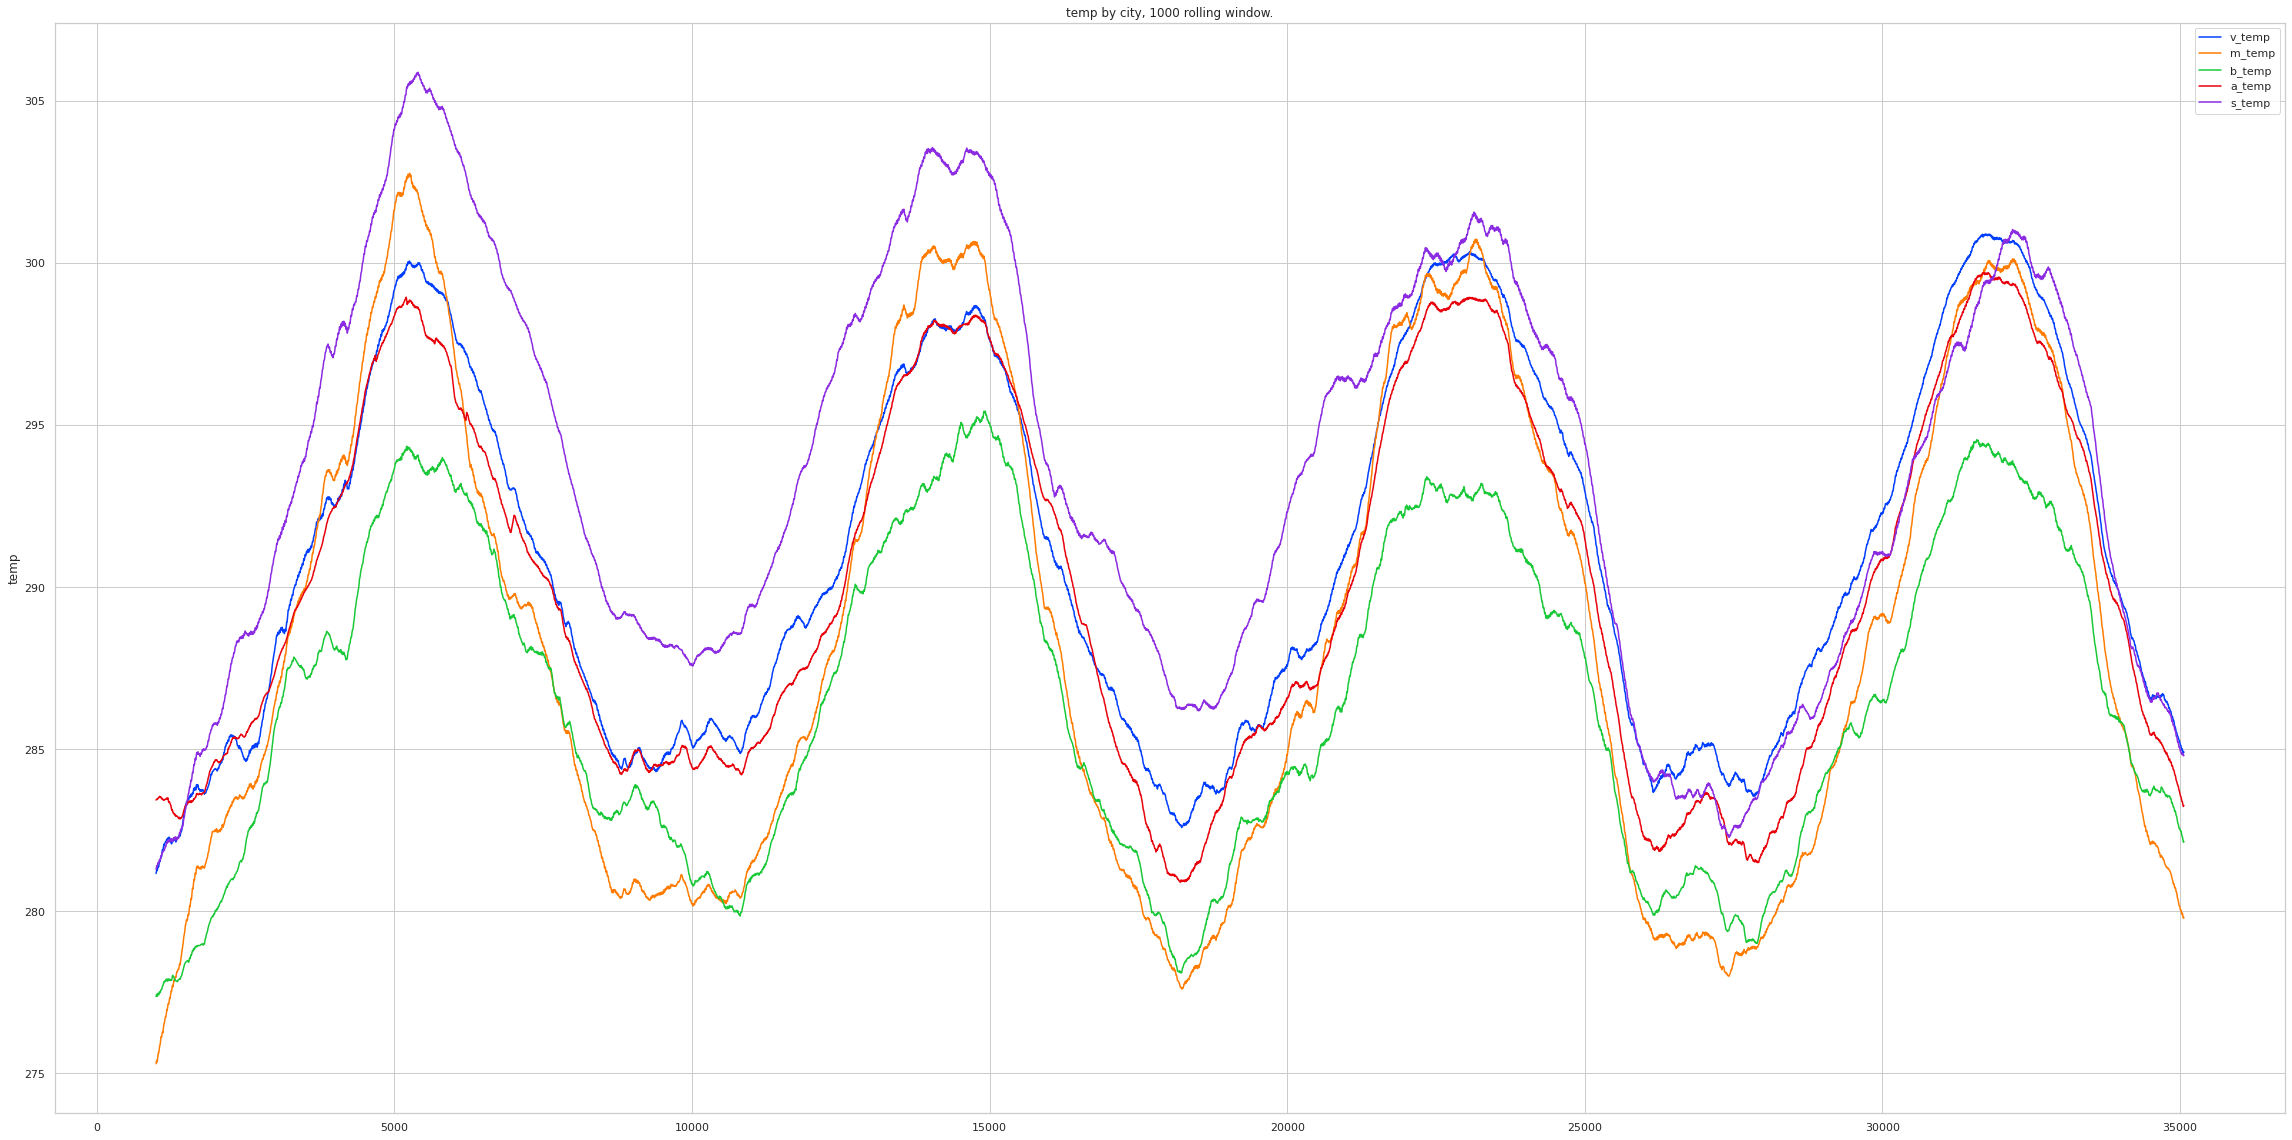

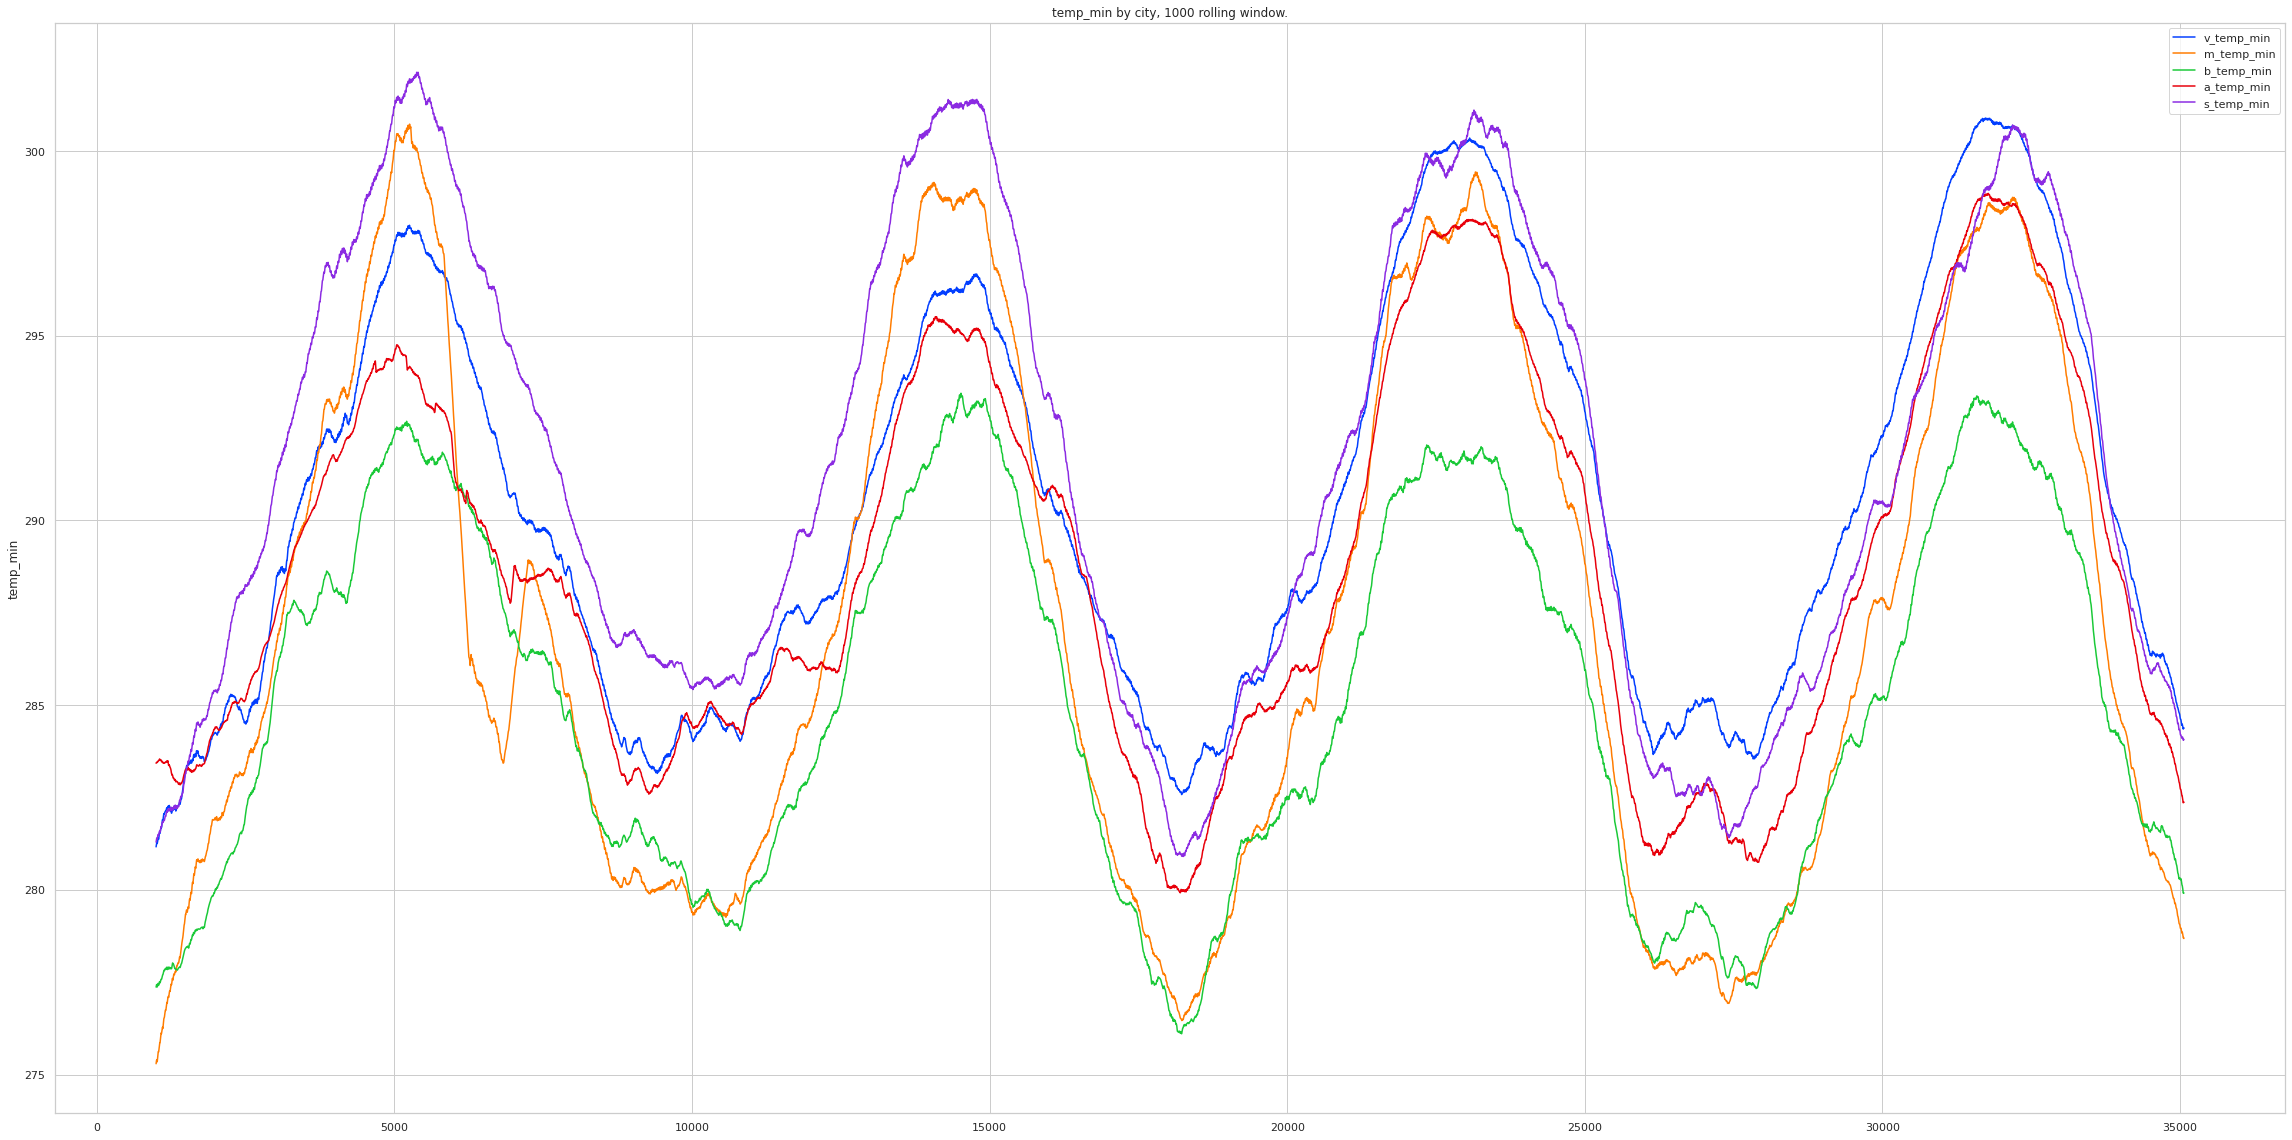

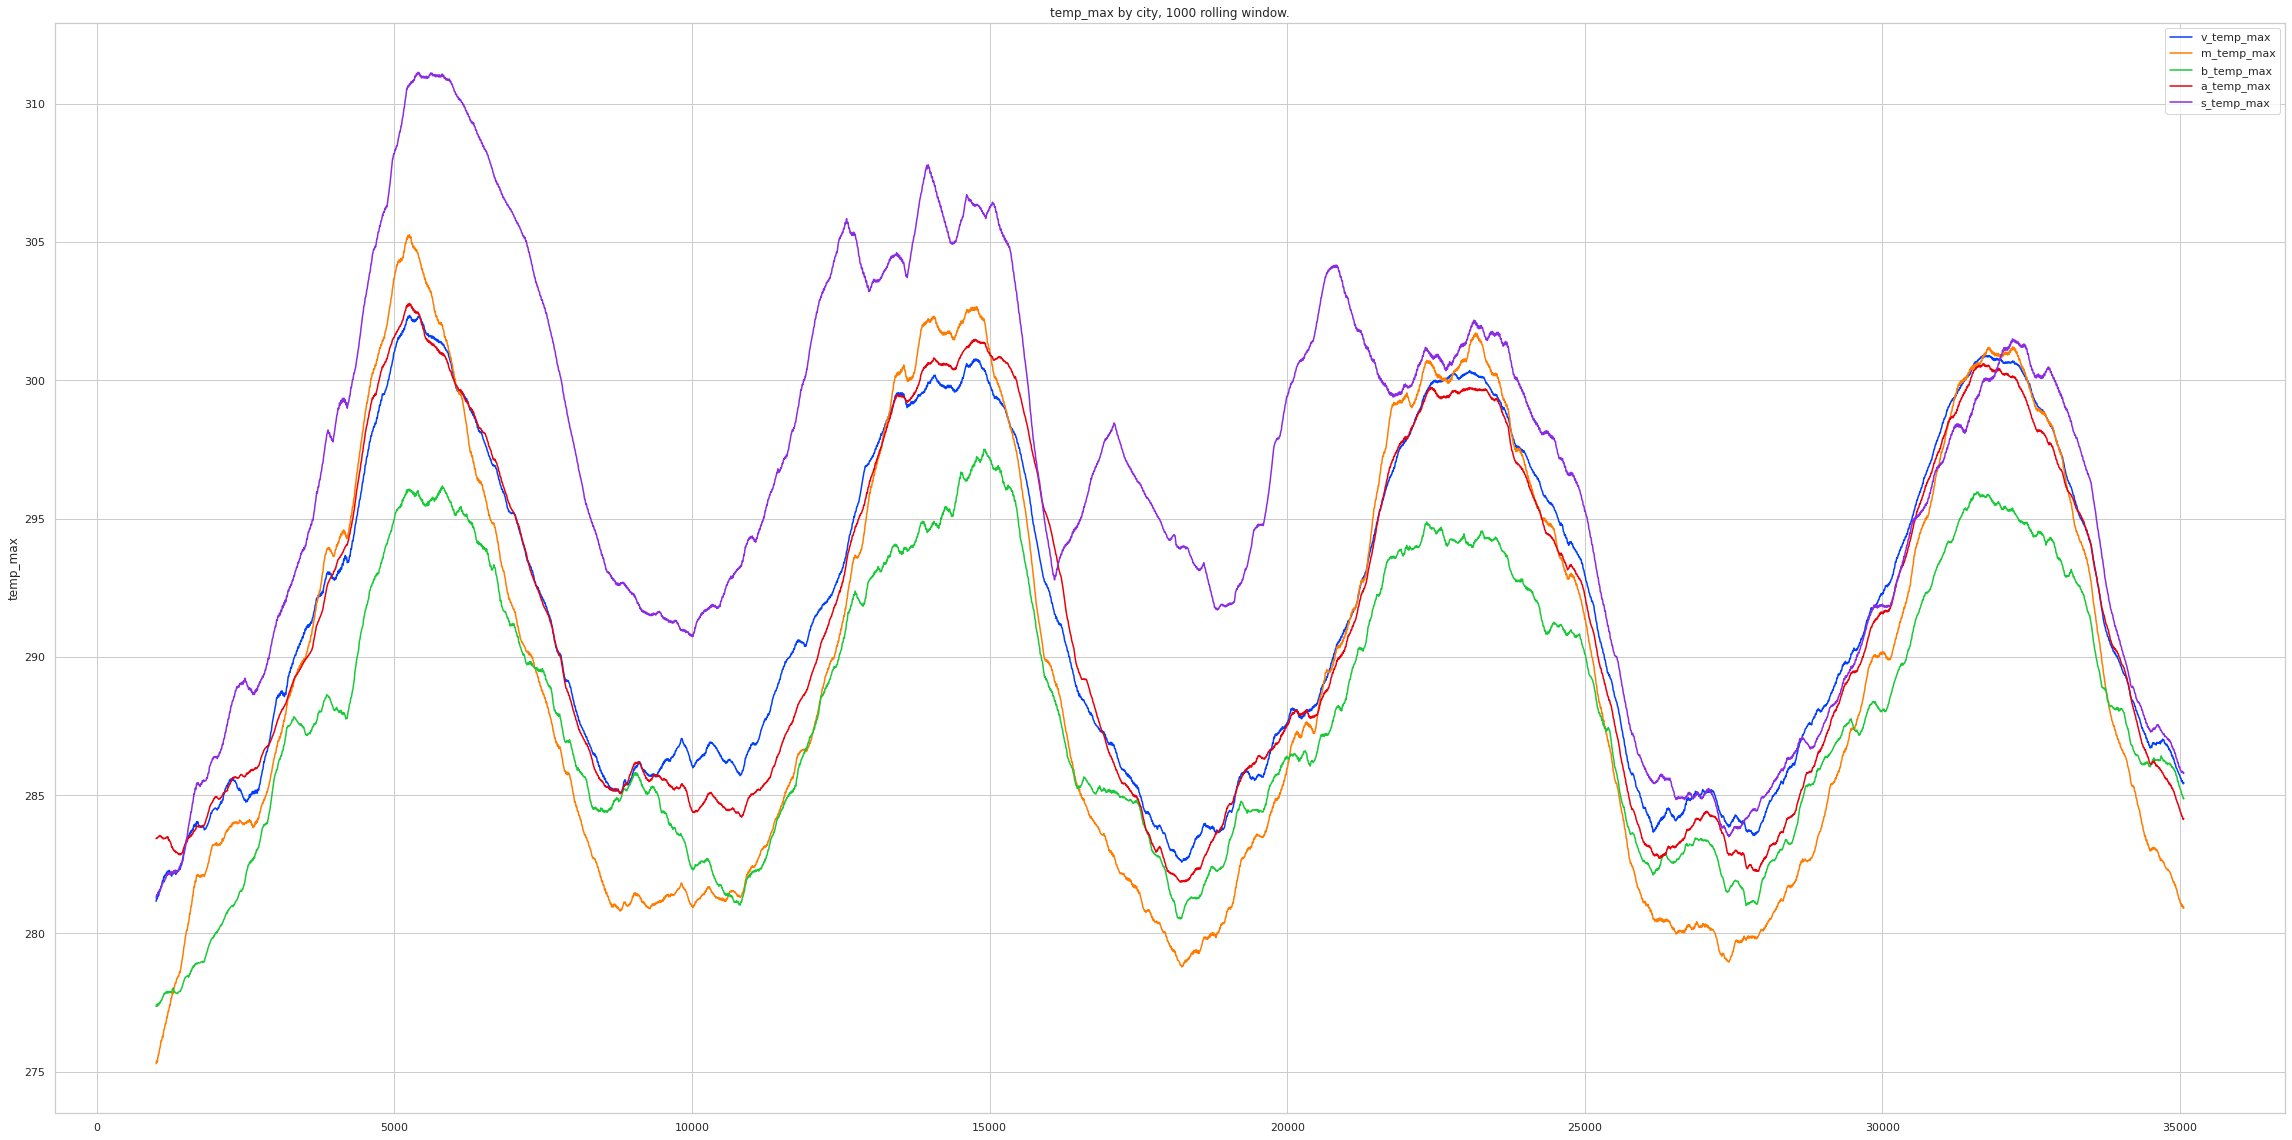

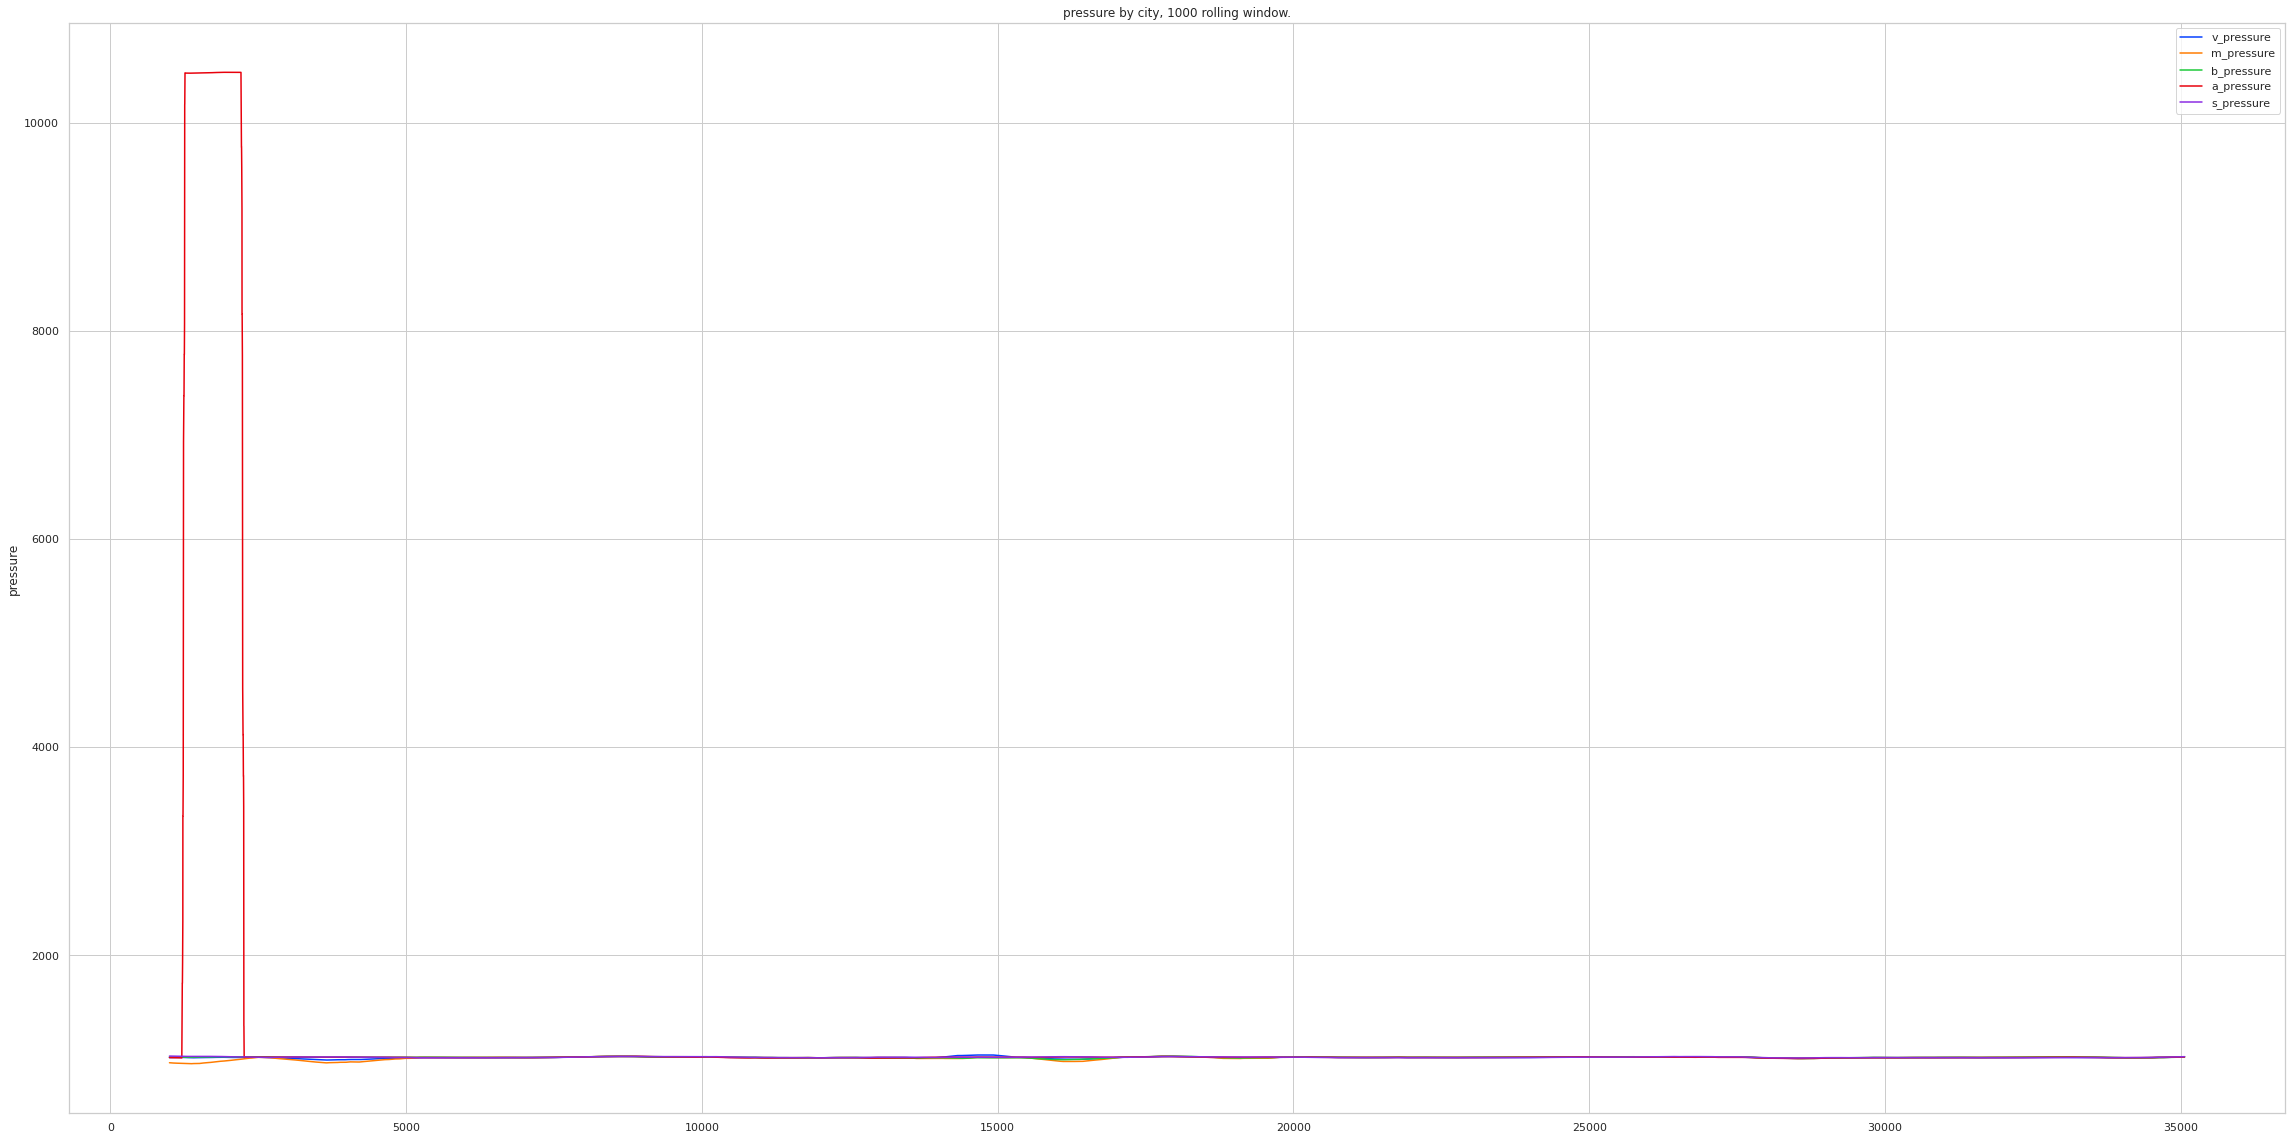

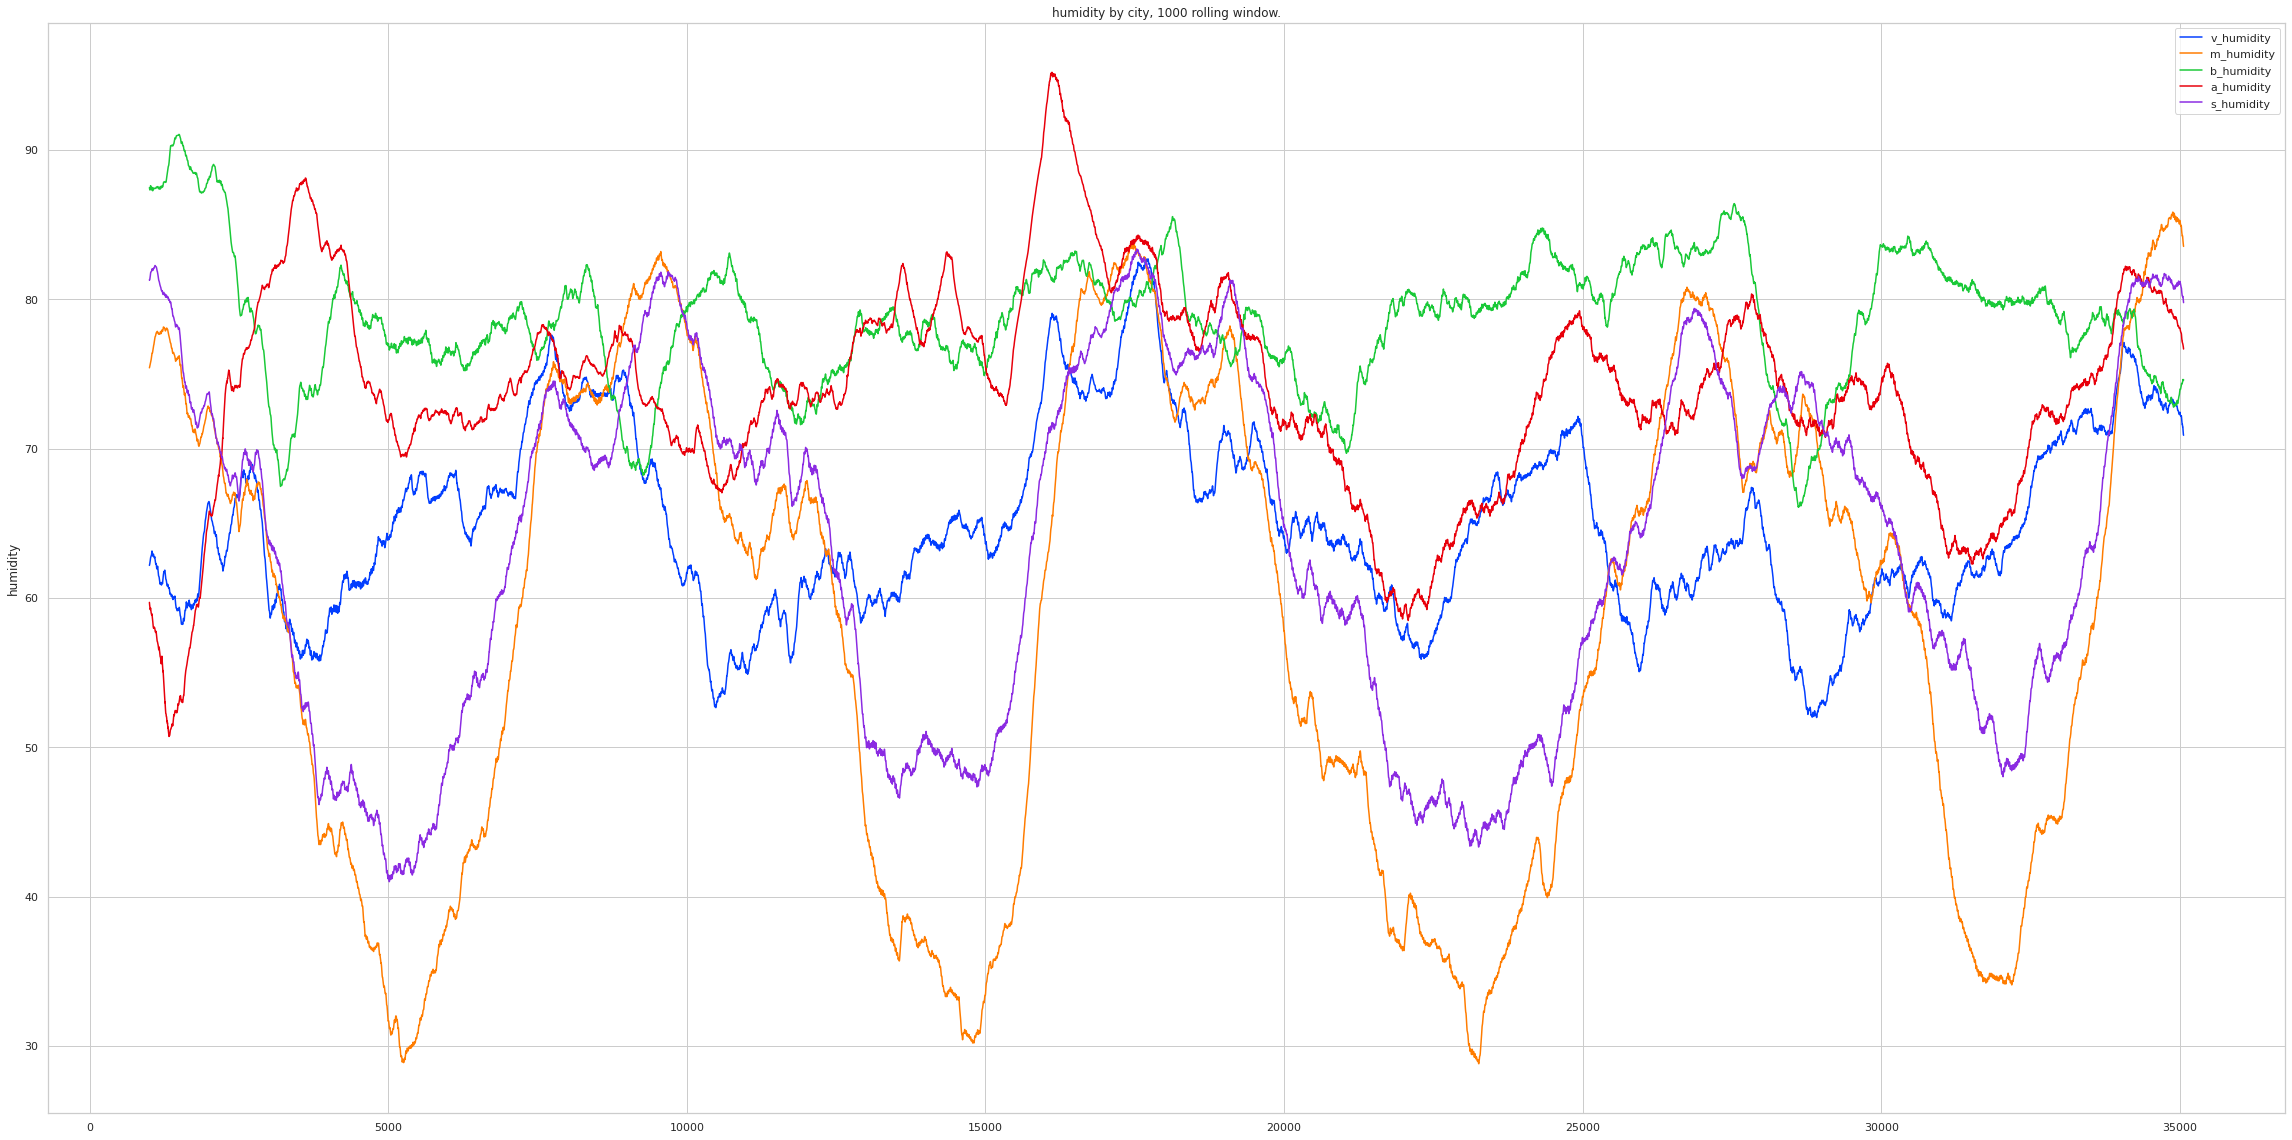

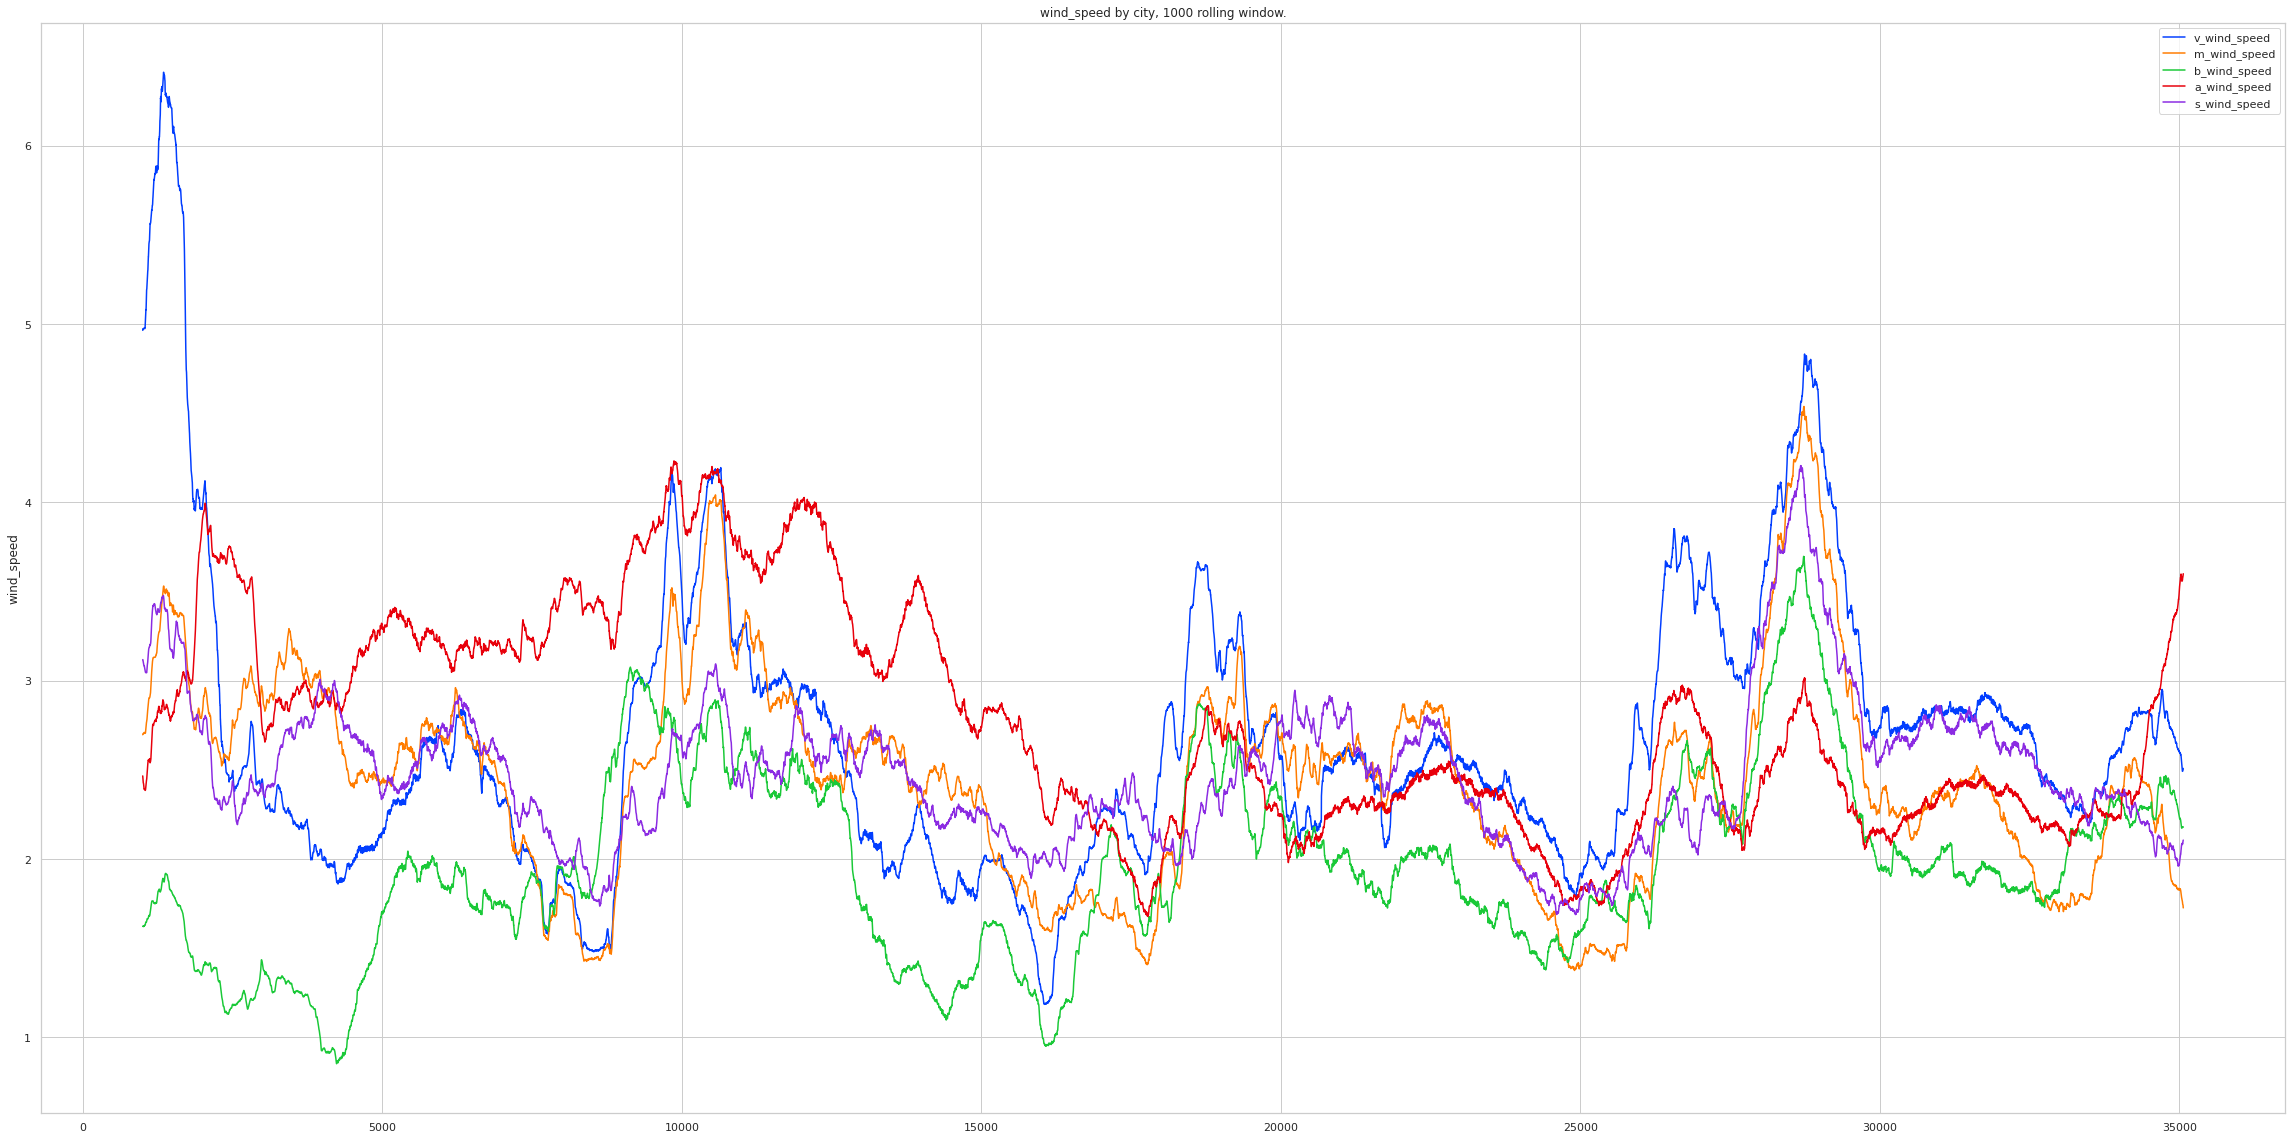

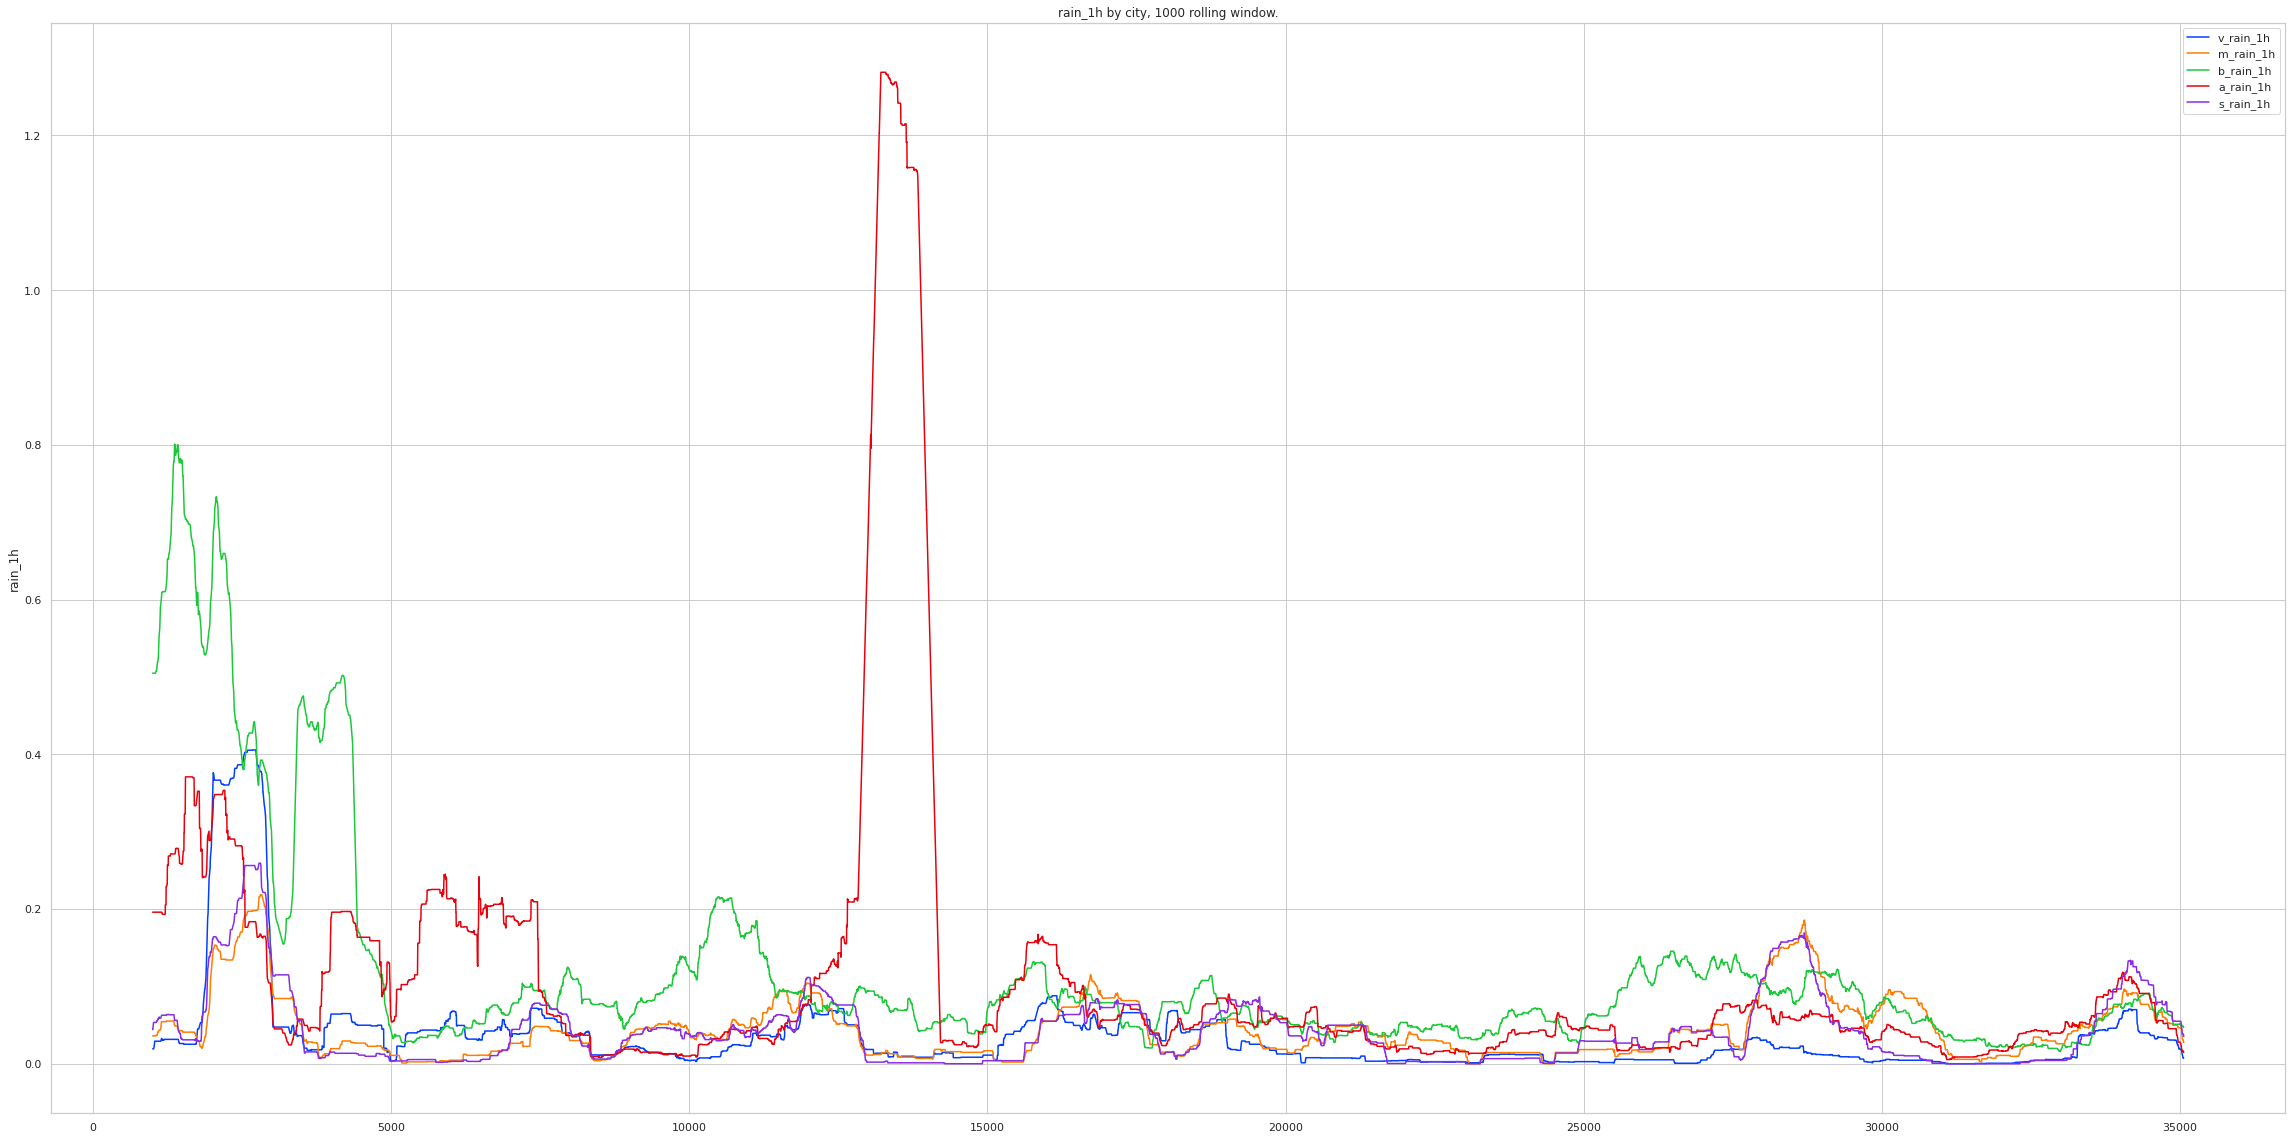

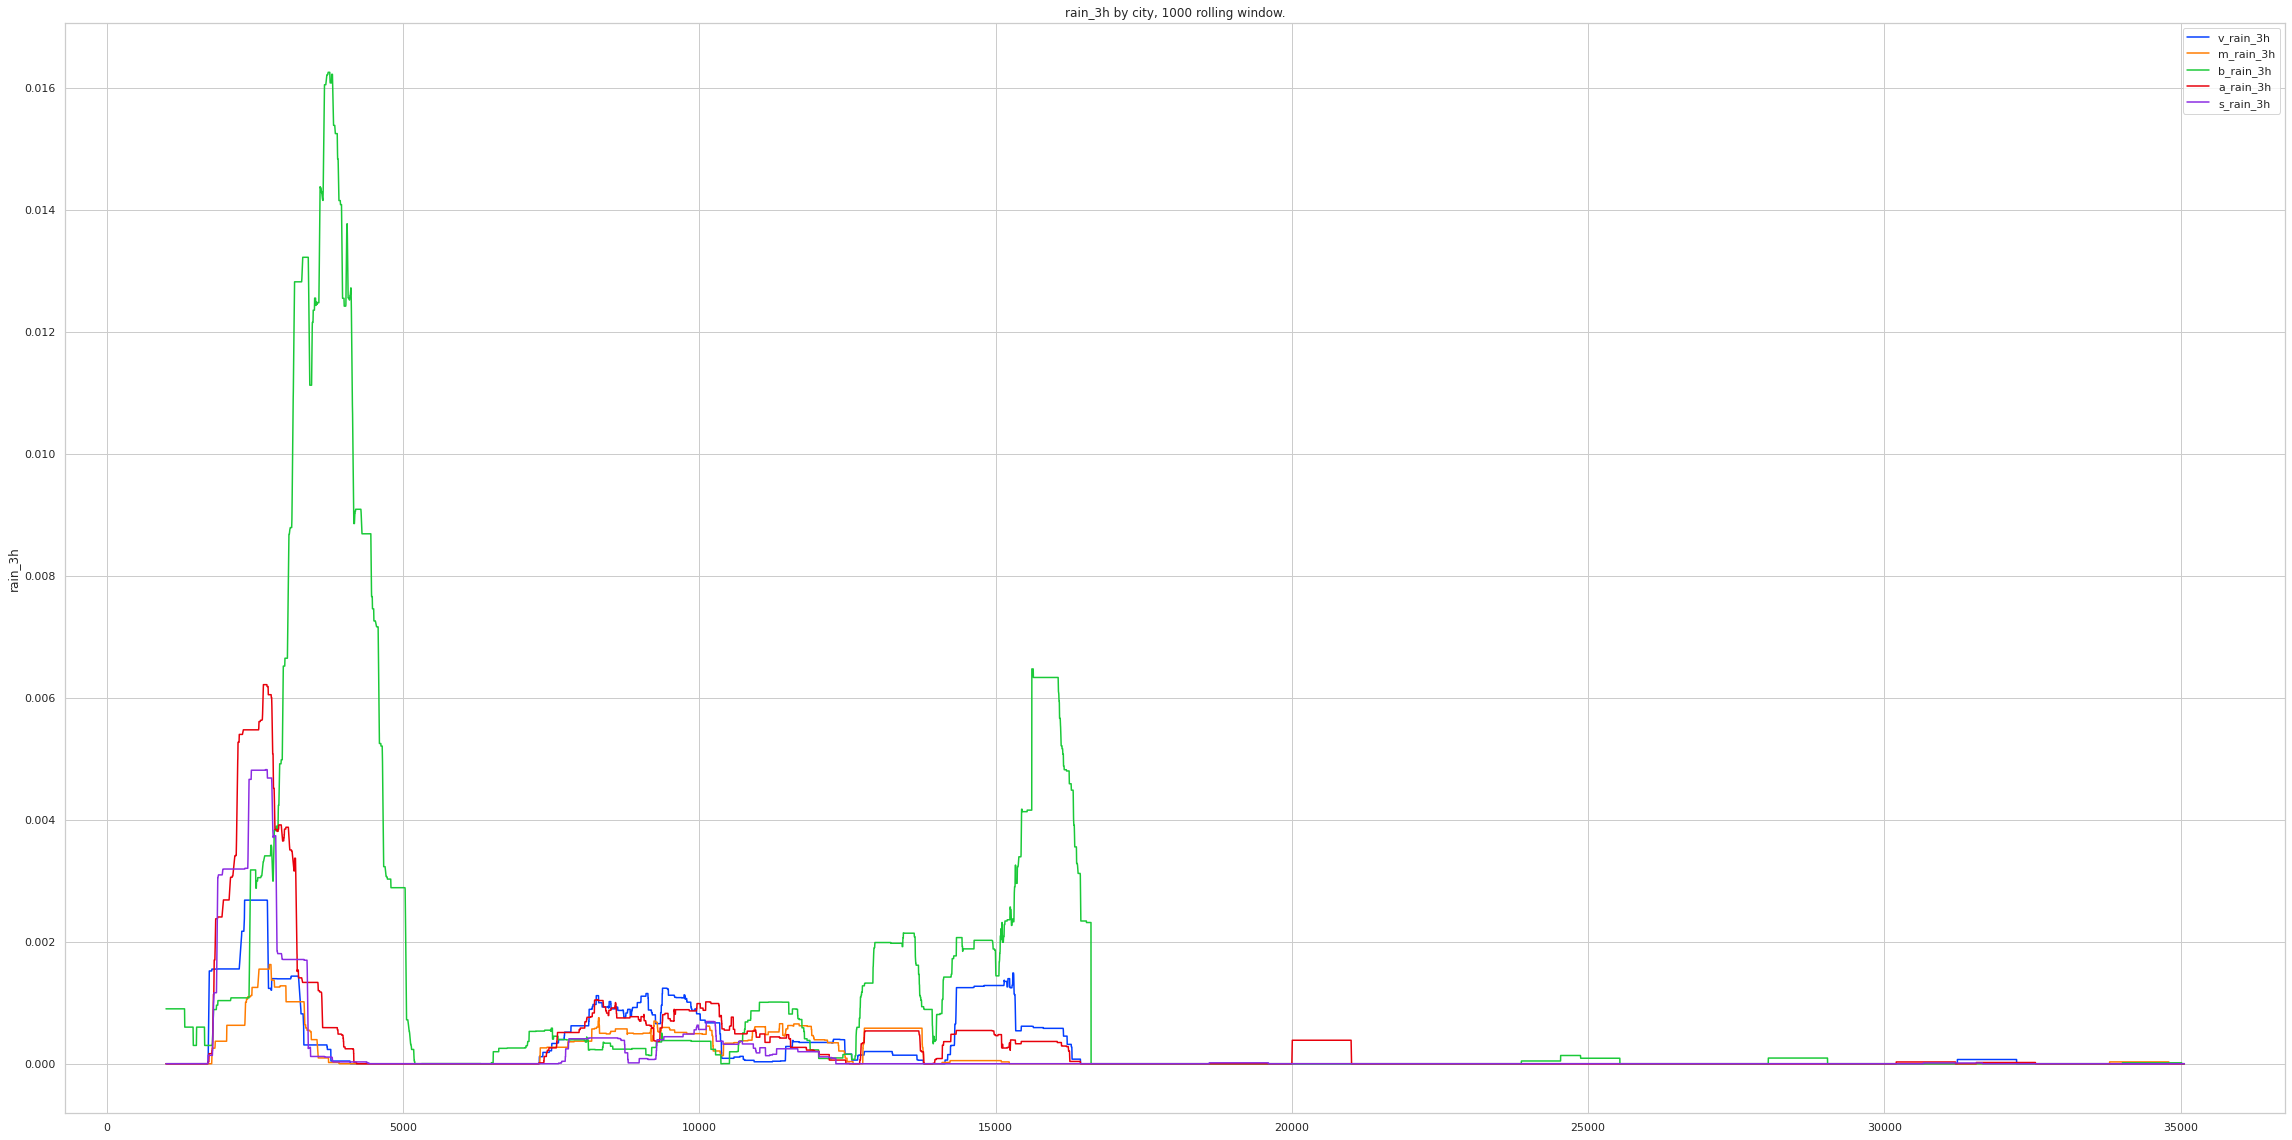

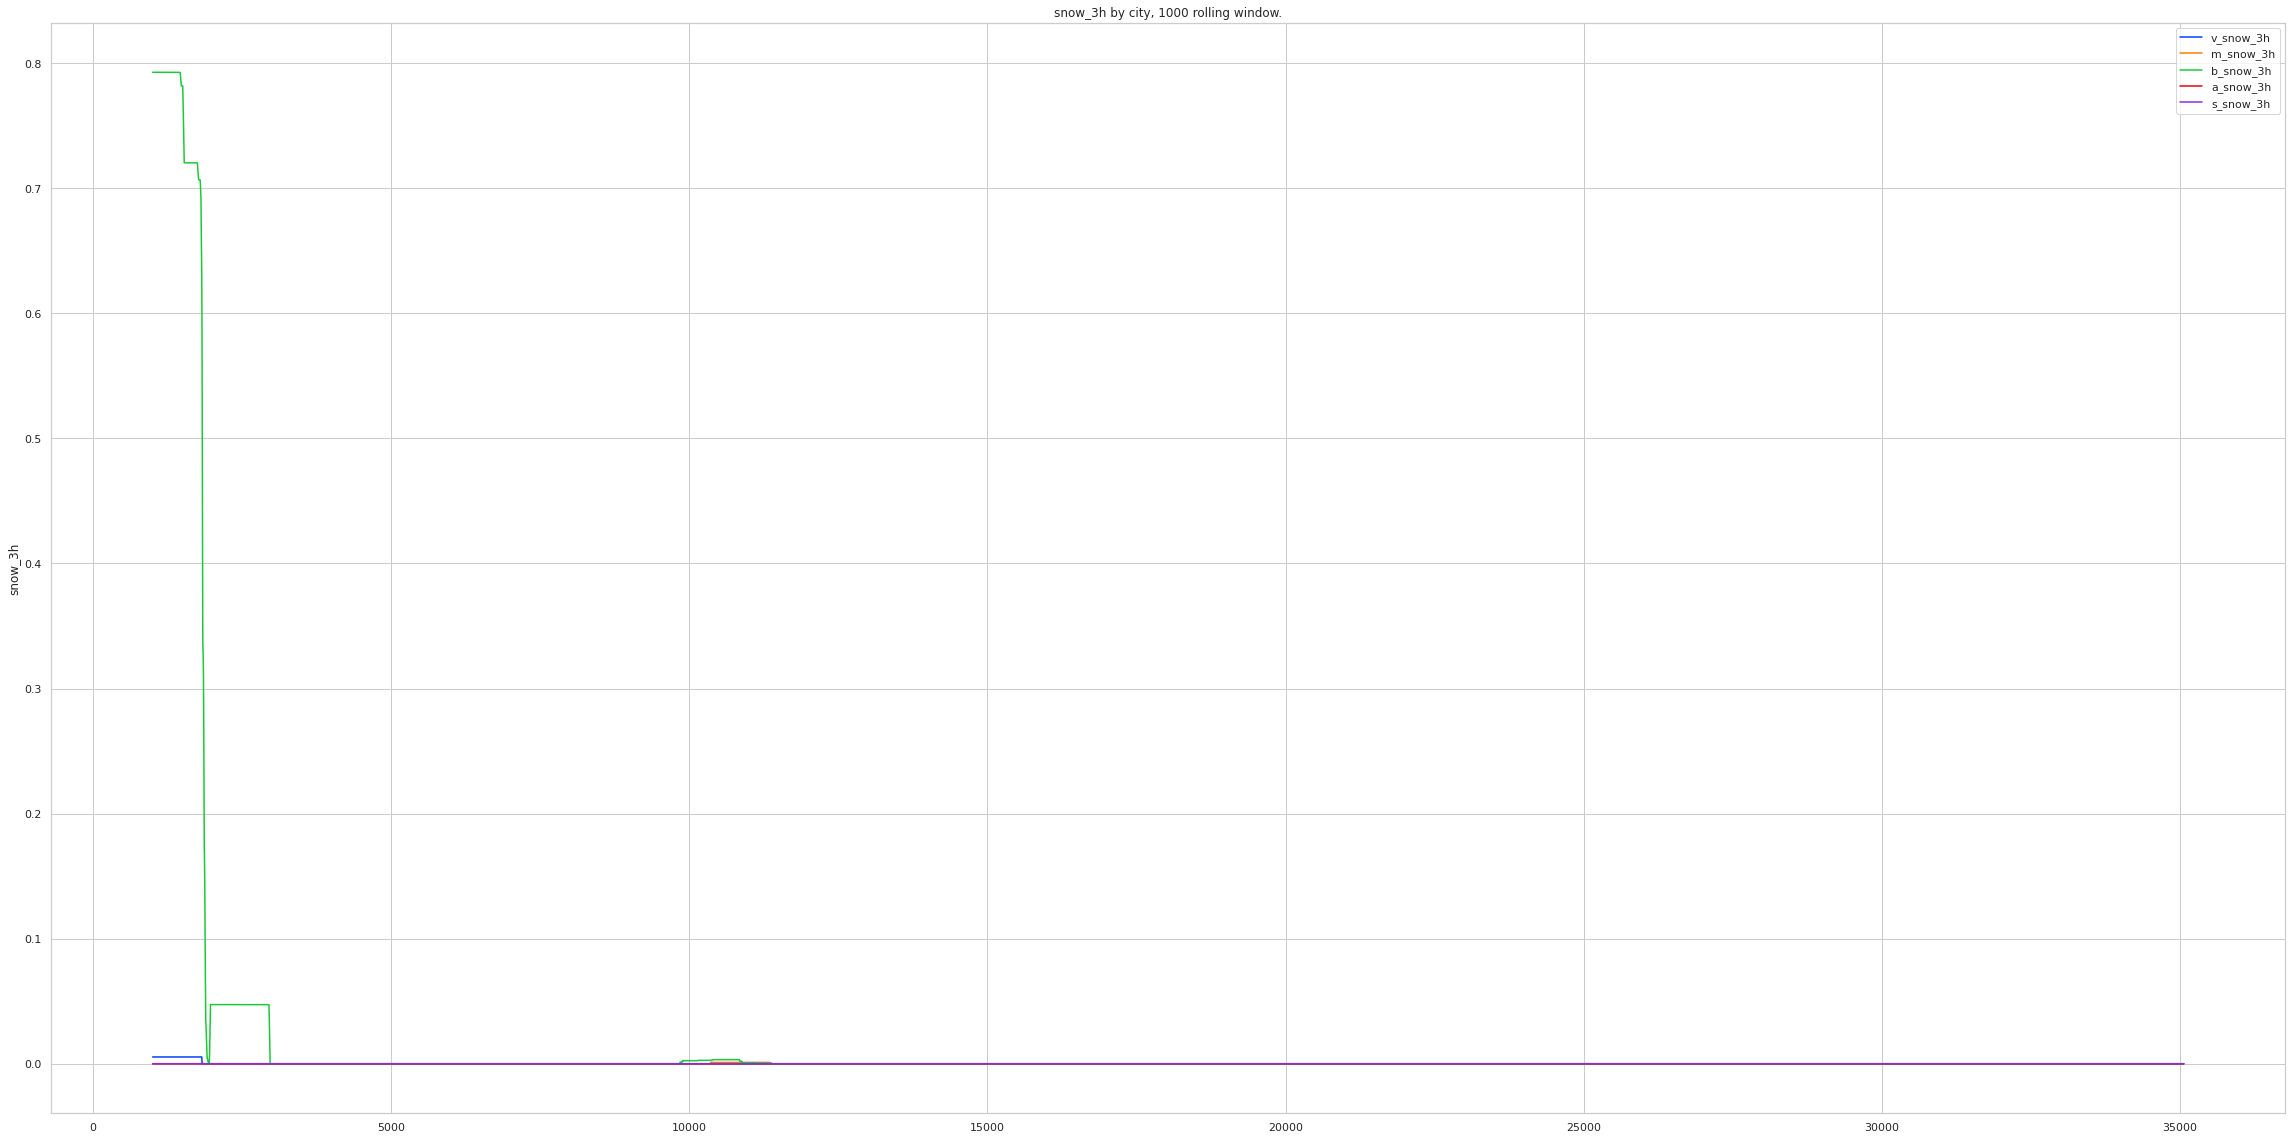

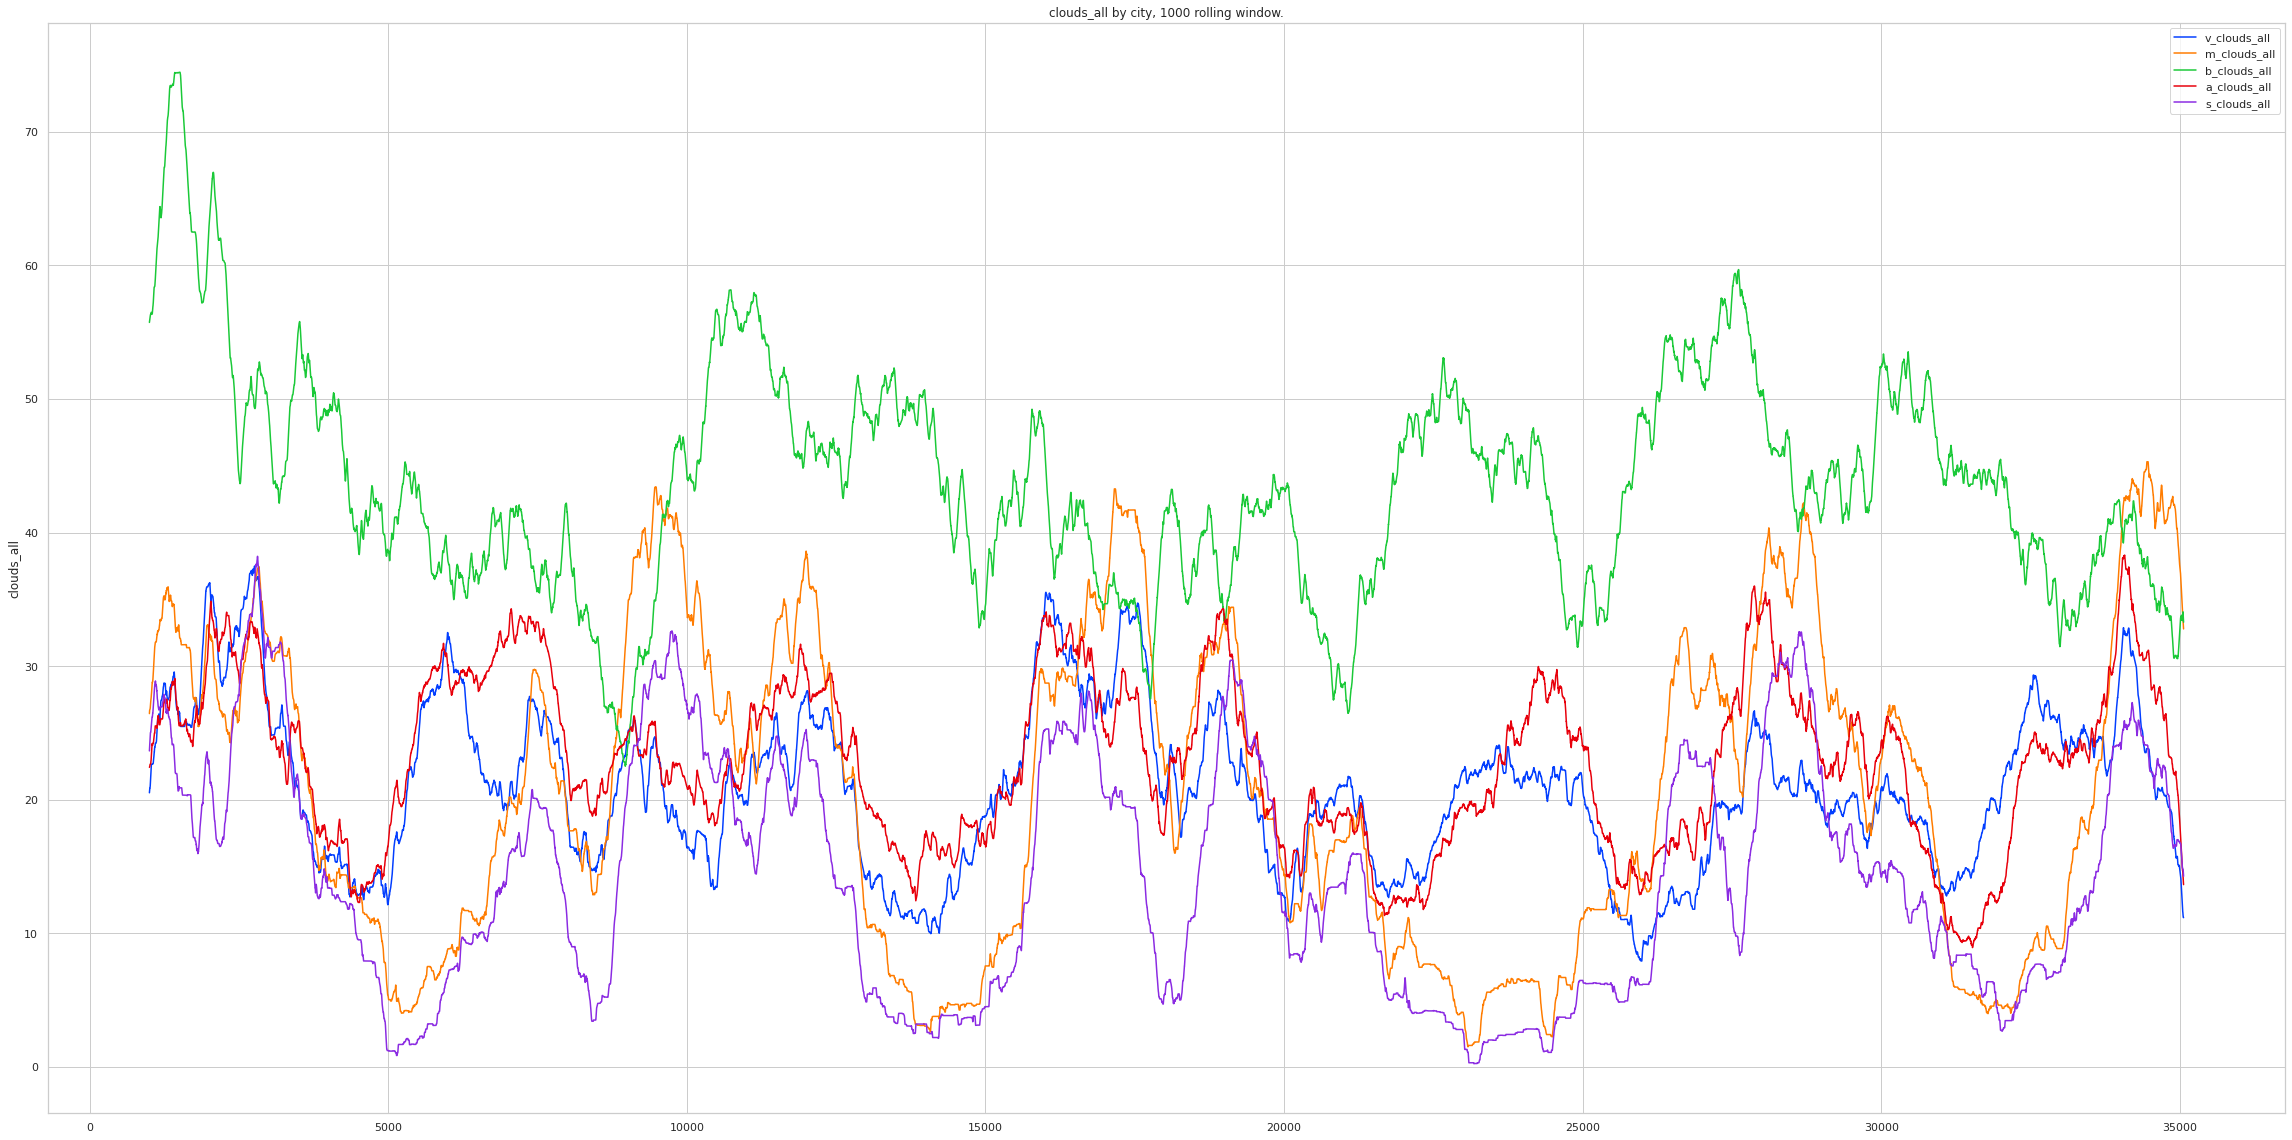

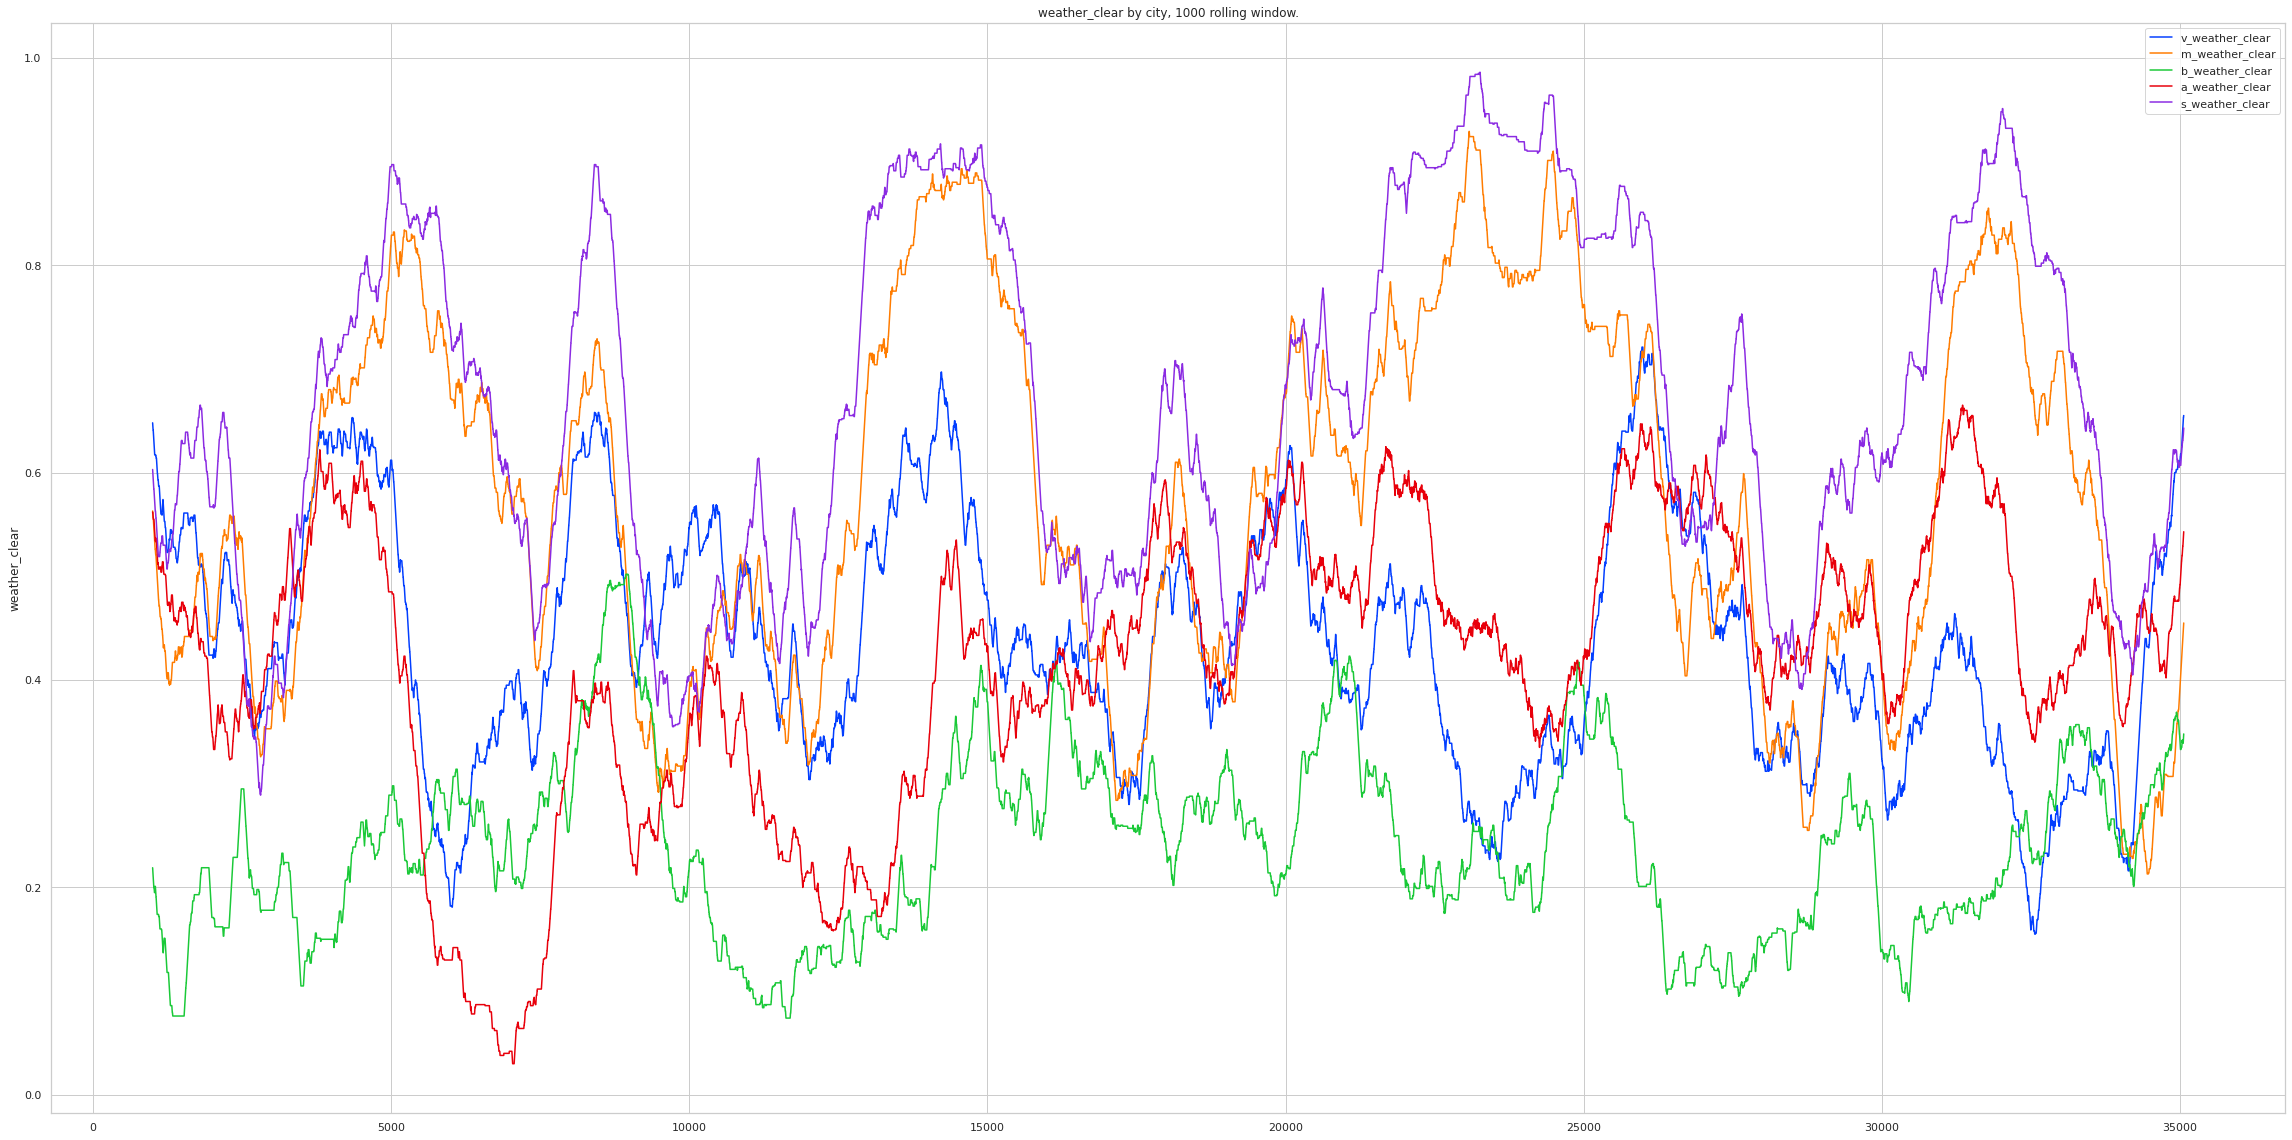

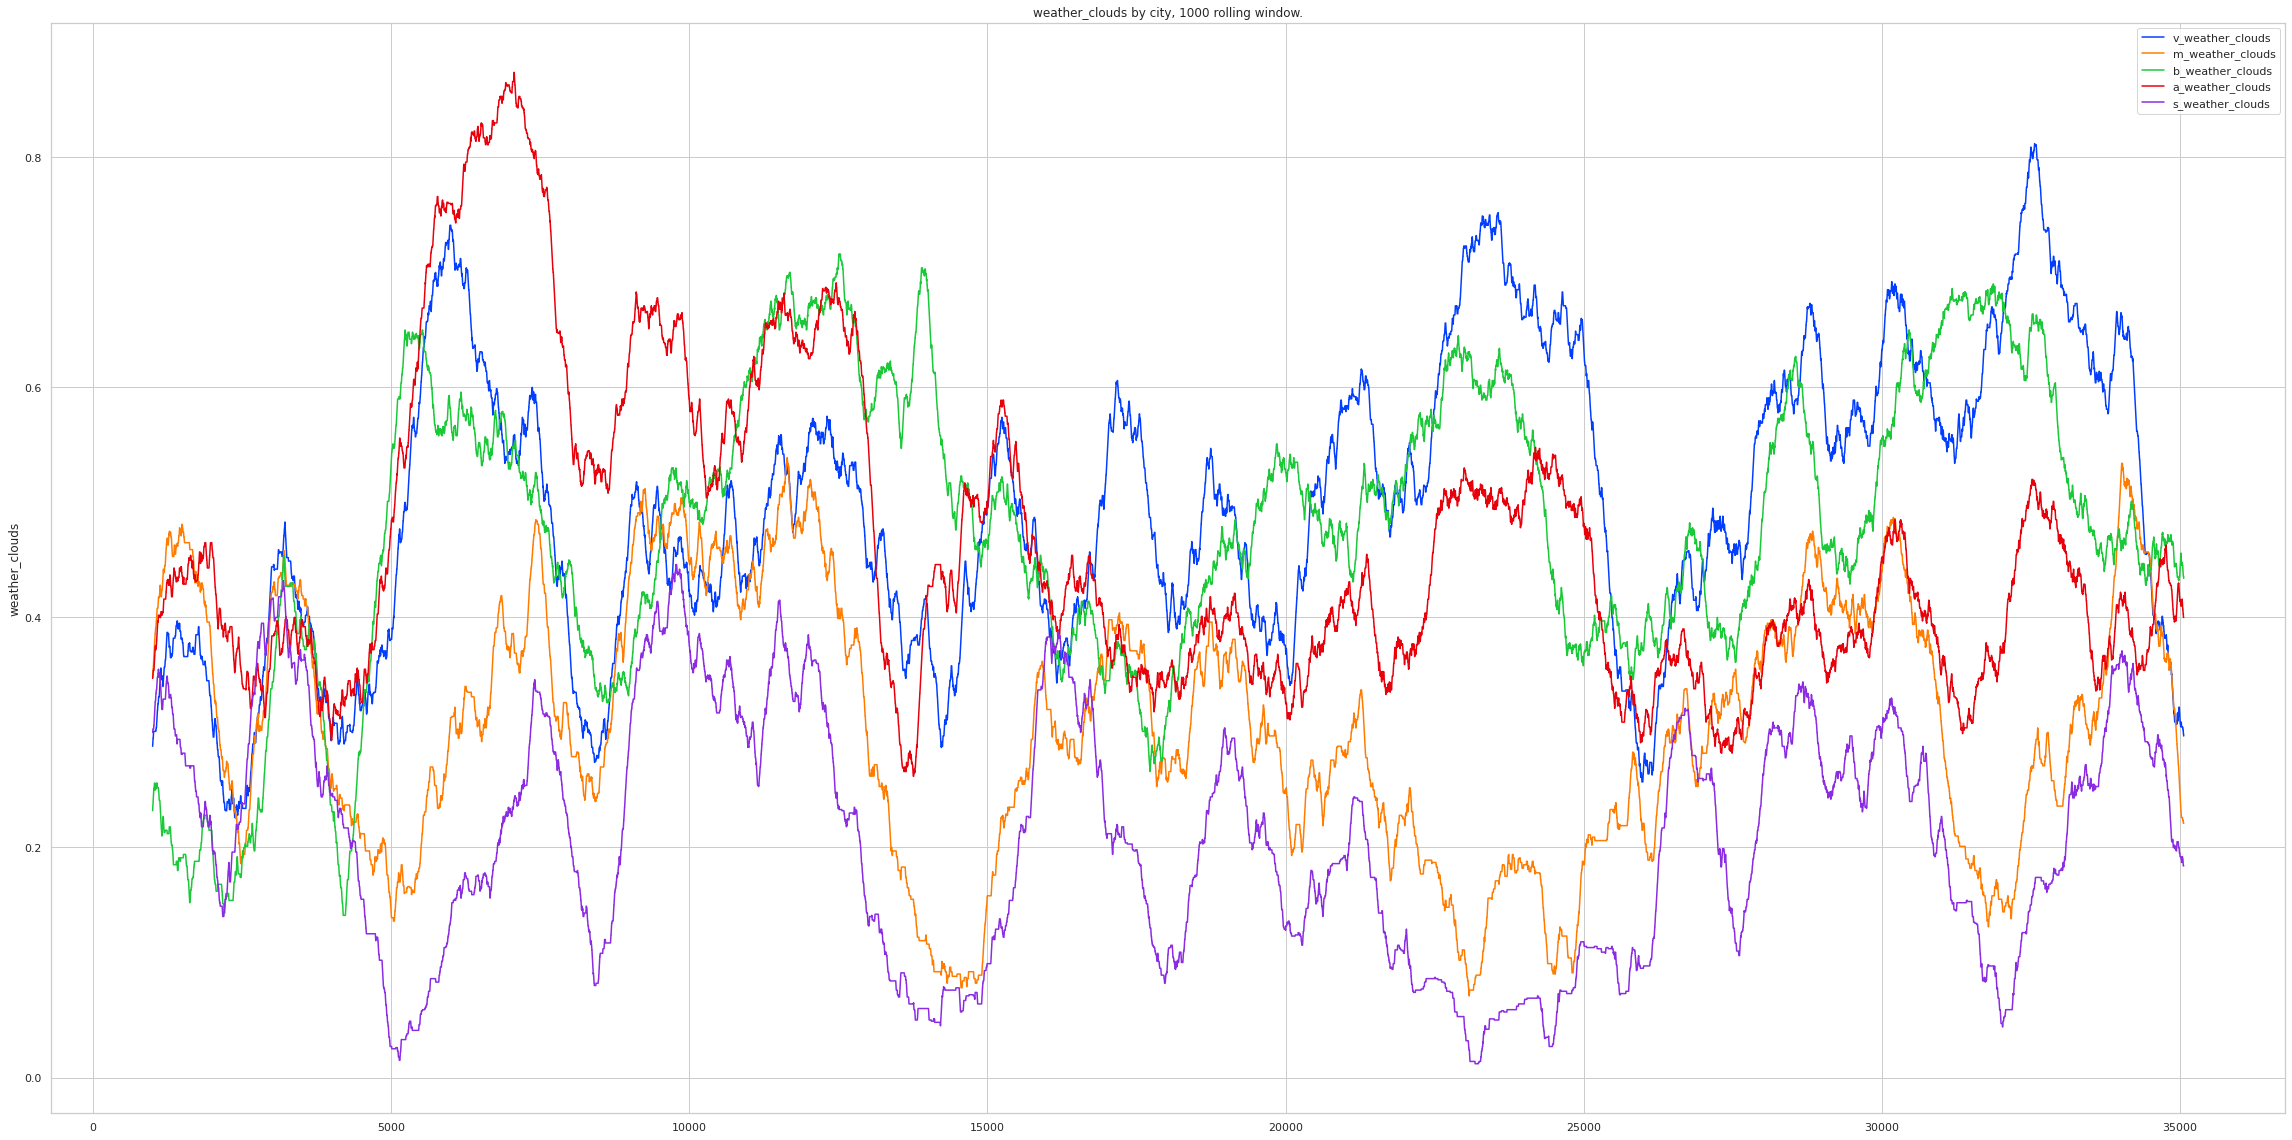

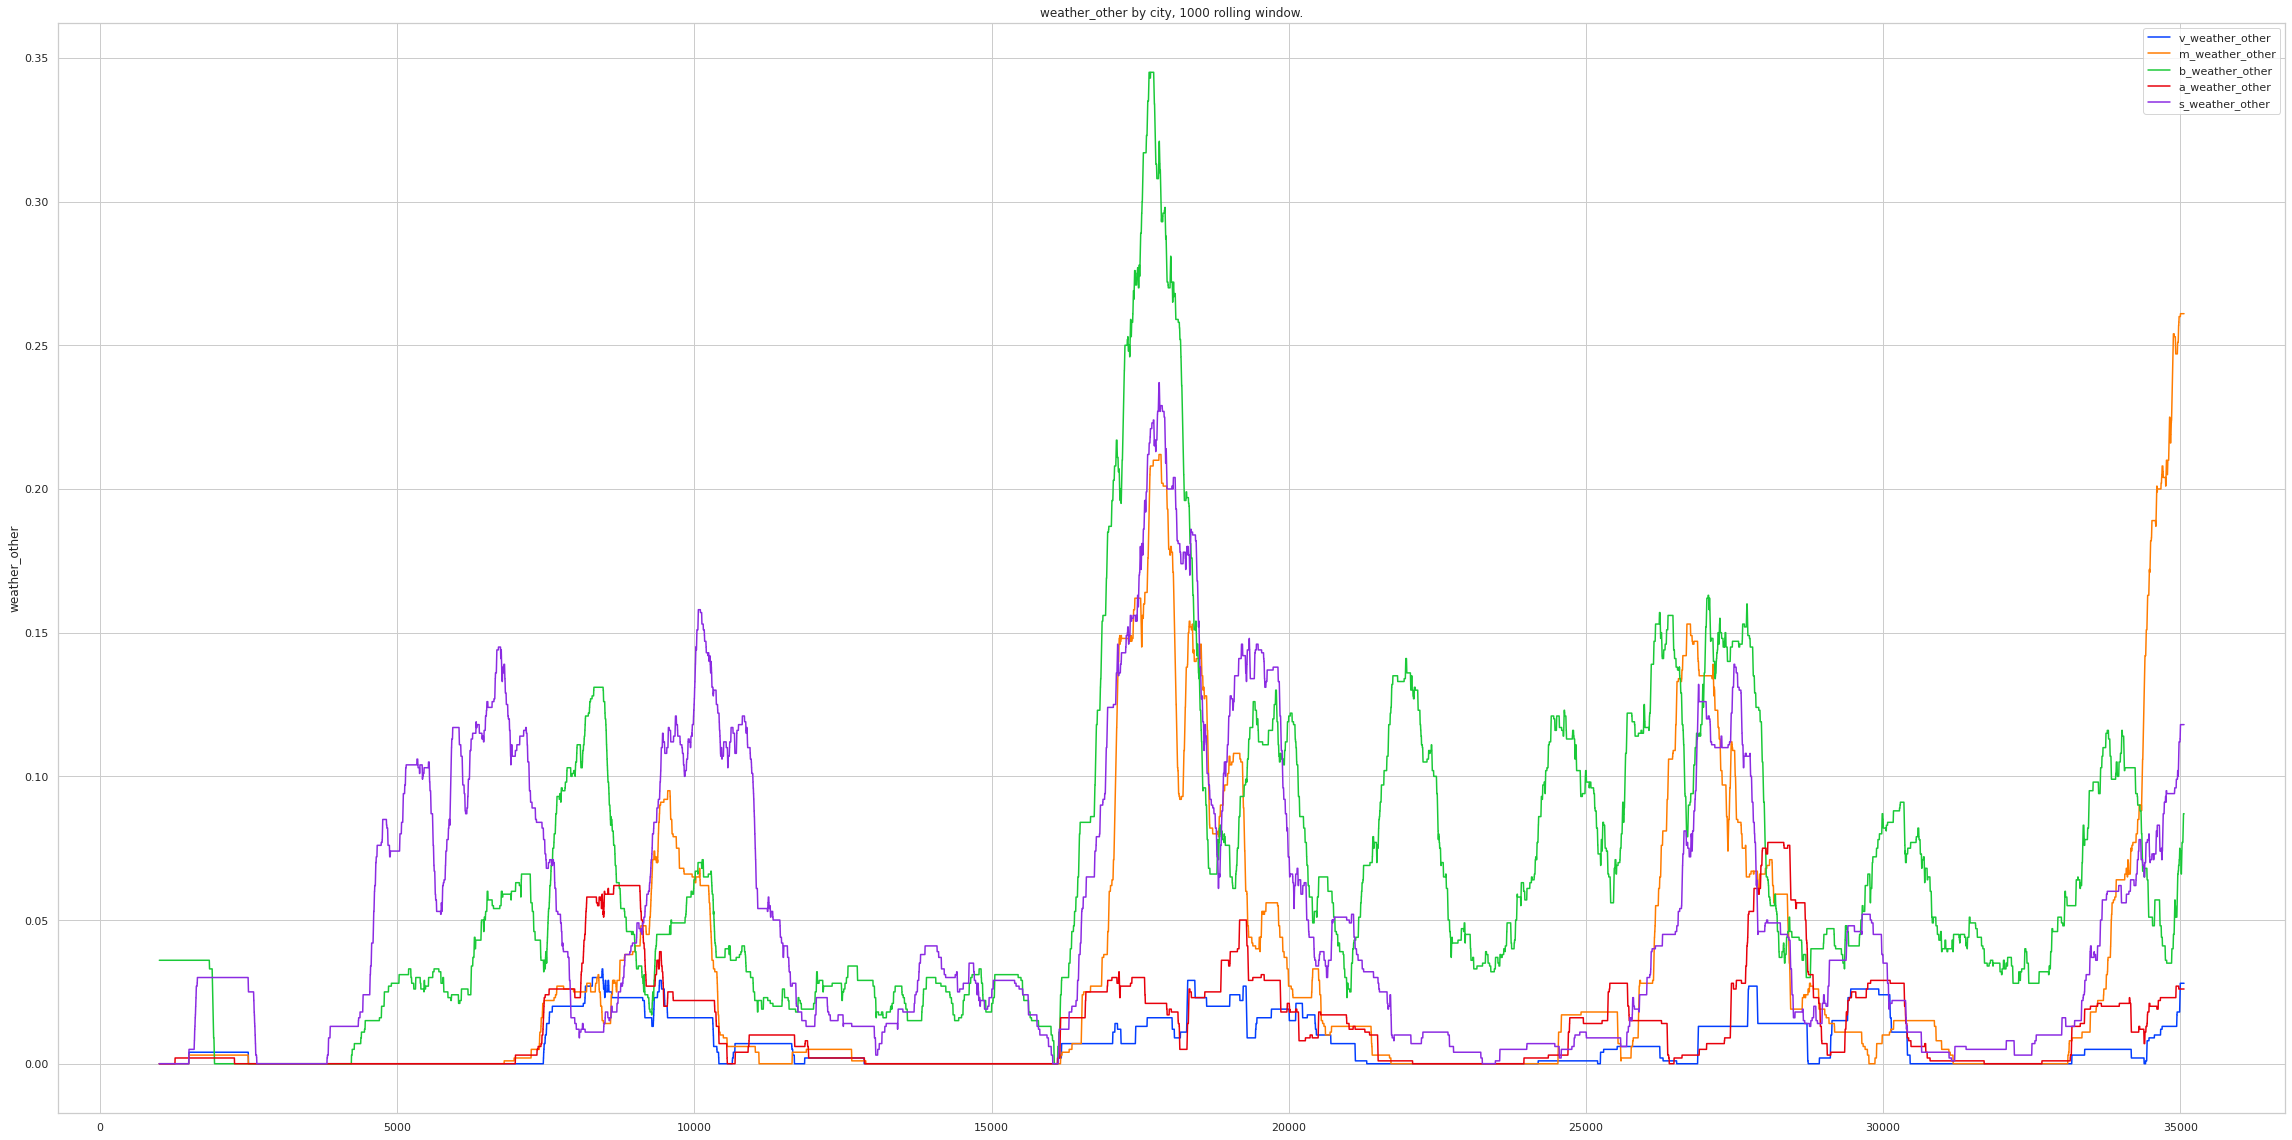

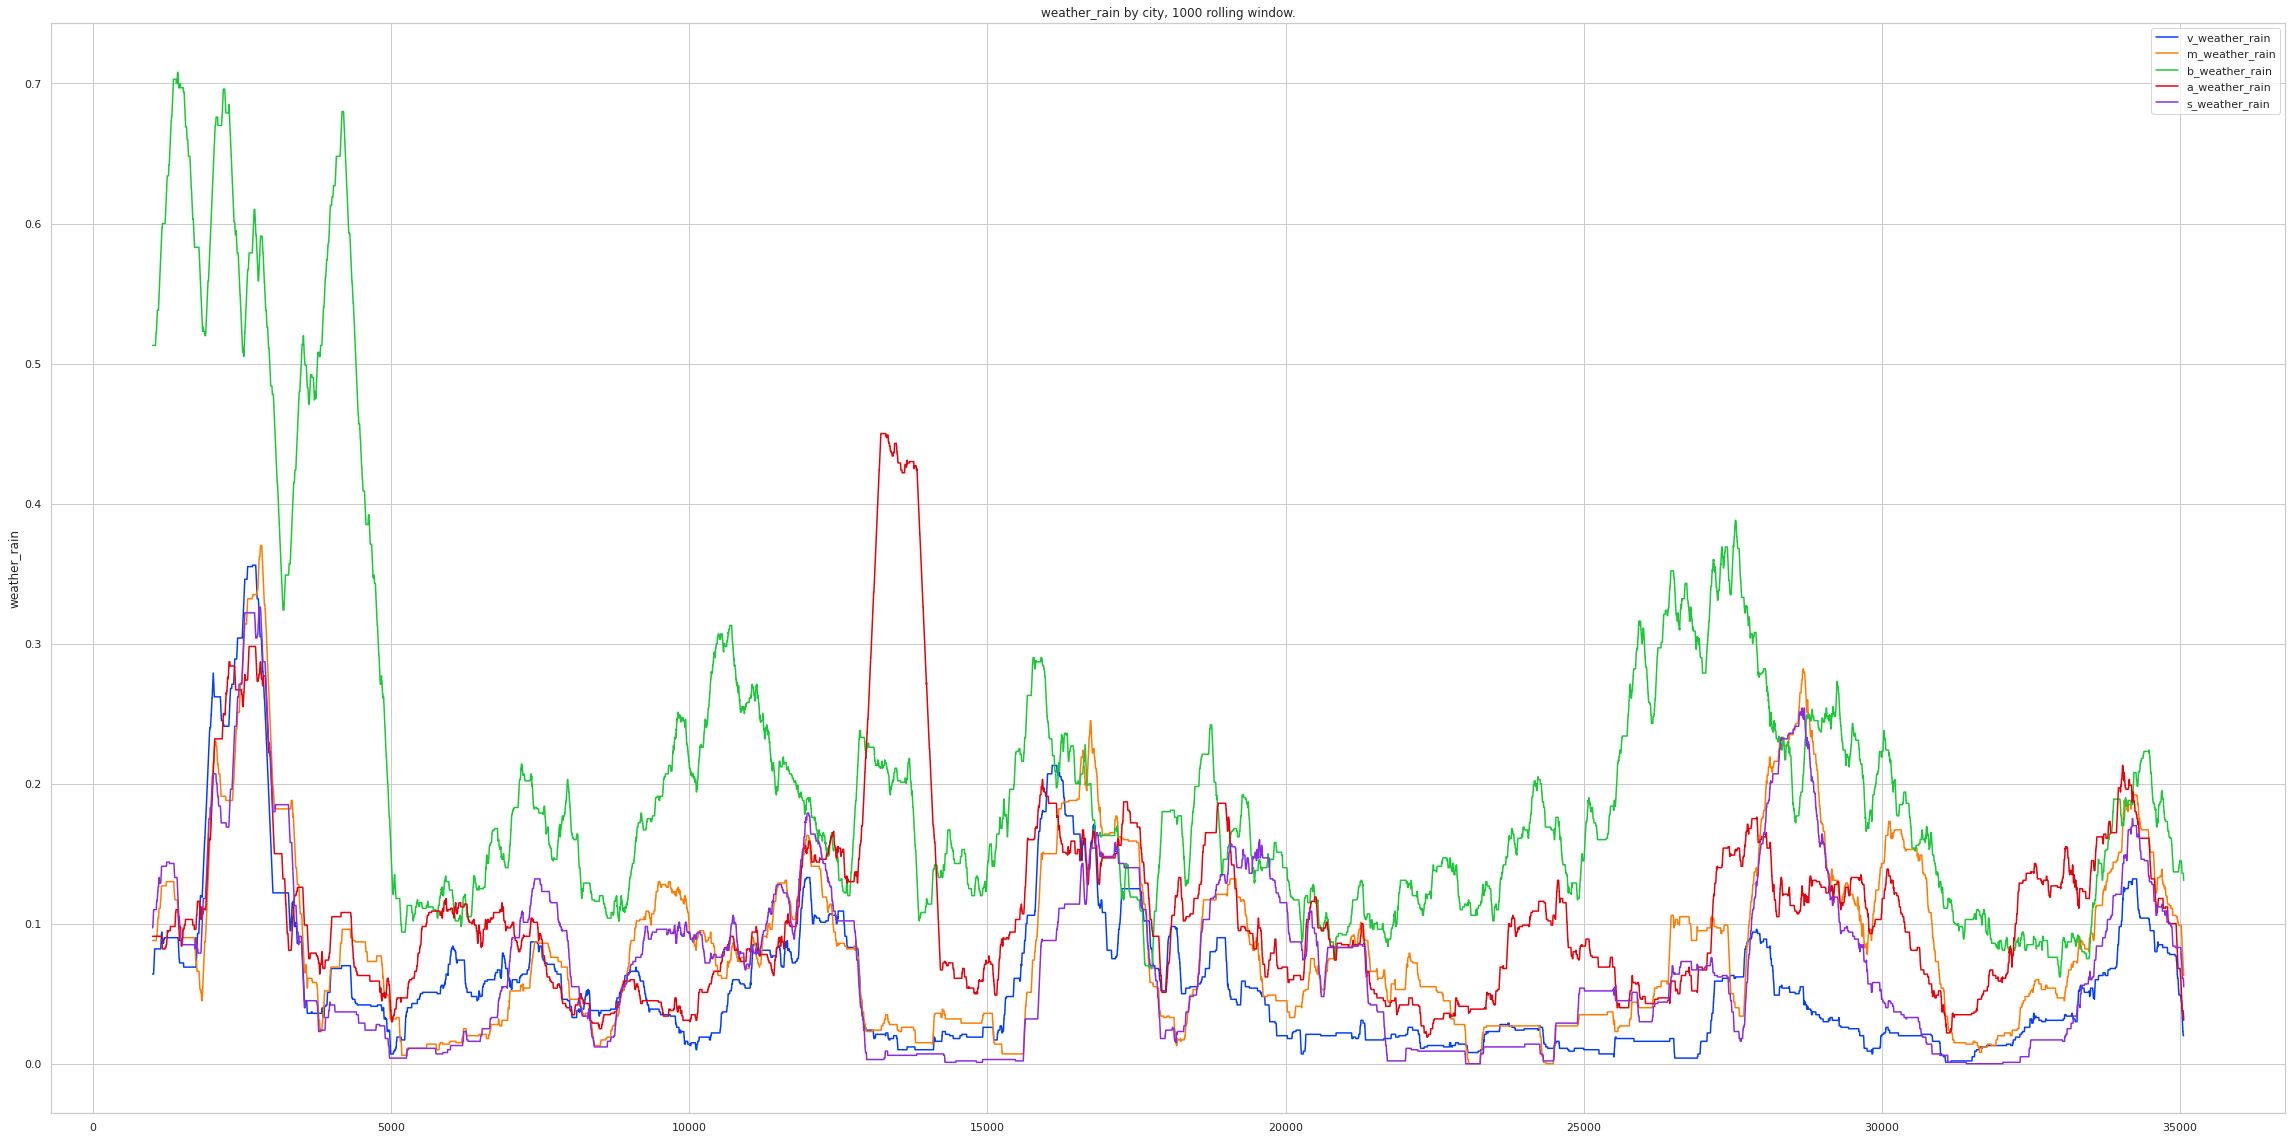

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


city_prefixes = ["v_", "m_", "b_", "a_", "s_"]
weather_column_types = ["temp", "temp_min", "temp_max", "pressure", "humidity", "wind_speed", 
                        "rain_1h", "rain_3h", "snow_3h", "clouds_all", "weather_clear", "weather_clouds", 
                        "weather_other", "weather_rain"]


sns.set_theme(style="whitegrid", palette="bright")
    
def plot_city_data(column, rolling_window):
    plt.figure(figsize=(32, 16))

    for city in city_prefixes:
        rolling_avg = combined_city_df[f"{city}{column}"].rolling(window=rolling_window).mean()
        sns.lineplot(data=combined_city_df, x=combined_city_df.index, y=rolling_avg, label=f"{city}{column}")

    plt.title(f"{column} by city, rolling window size: {rolling_window}.")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

for column_type in weather_column_types:
    plot_city_data(column_type, 1000)


<h3>Averaging Columns</h3>

In [ ]:
# # Weighted averages of the columns based on a population density map of Spain. 

# combined_city_df['avg_temp'] = combined_city_df['v_temp']*0.2 + combined_city_df['m_temp']*0.3 + combined_city_df['b_temp']*0.1 + combined_city_df['a_temp']*0.3 + combined_city_df['s_temp']*0.1
# combined_city_df['avg_humidity'] = combined_city_df['v_humidity']*0.2 + combined_city_df['m_humidity']*0.3 + combined_city_df['b_humidity']*0.1 + combined_city_df['a_humidity']*0.3 + combined_city_df['s_humidity']*0.1
# combined_city_df['avg_wind_speed'] = combined_city_df['v_wind_speed']*0.2 + combined_city_df['m_wind_speed']*0.3 + combined_city_df['b_wind_speed']*0.1 + combined_city_df['a_wind_speed']*0.3 + combined_city_df['s_wind_speed']*0.1
# combined_city_df['avg_rain_1h'] = combined_city_df['v_rain_1h']*0.2 + combined_city_df['m_rain_1h']*0.3 + combined_city_df['b_rain_1h']*0.1 + combined_city_df['a_rain_1h']*0.3 + combined_city_df['s_rain_1h']*0.1
# combined_city_df['avg_clouds_all'] = combined_city_df['v_clouds_all']*0.2 + combined_city_df['m_clouds_all']*0.3 + combined_city_df['b_clouds_all']*0.1 + combined_city_df['a_clouds_all']*0.3 + combined_city_df['s_clouds_all']*0.1

# # Rounding new columns: 
# combined_city_df["avg_temp"] = combined_city_df["avg_temp"].round(1)
# combined_city_df["avg_humidity"] = combined_city_df["avg_humidity"].round(1)
# combined_city_df["avg_wind_speed"] = combined_city_df["avg_wind_speed"].round(1)
# combined_city_df["avg_rain_1h"] = combined_city_df["avg_rain_1h"].round(1)
# combined_city_df["avg_clouds_all"] = combined_city_df["avg_clouds_all"].round(1)

# combined_city_df.to_csv("combined_city_df.csv", index=False)

# weather_df_1 = combined_city_df[["avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", "avg_clouds_all"]]

# weather_df_1.to_csv("weather_df_1.csv", index=False)

